# 데이터셋 준비

In [ ]:
!pip install pydicom

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# IMA이미지를 불러오는 라이브러리
import pydicom

import numpy as np
import torch
import torchvision.transforms as transforms
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.figsize'] = [3.0, 3.0]
import seaborn as sns
import torch.nn as nn

In [ ]:
root = '/content/drive/MyDrive'

## 데이터셋 관련 (공통)

In [ ]:
import glob

L_list = glob.glob(f'{root}/mayo2016/*')
L_list = [path.split('/')[-1] for path in L_list]
L_list.sort()
L_list

['L067',
 'L096',
 'L109',
 'L143',
 'L192',
 'L286',
 'L291',
 'L310',
 'L333',
 'L506']

In [ ]:
data_label = ['quarter_1mm', 'full_1mm']

In [ ]:
def normlize(path):
  dicom_data = pydicom.dcmread(path)
  img = dicom_data.pixel_array.astype(np.float32) * dicom_data.RescaleSlope + dicom_data.RescaleIntercept
  mu, sd = (-500,500)
  scaled_img = (img - mu) / sd
  img = np.expand_dims(scaled_img, axis=0)

  return img # 1x512x512

In [ ]:
def extract_patches(img, patch_size=55, interval=55):
  patches = []
  _, height, width = img.shape
  for y in range(0, height - patch_size + 1, interval):
    for x in range(0, width - patch_size + 1, interval):
      patch = img[:, y:y + patch_size, x:x + patch_size]
      patches.append(patch)
  patches = np.array(patches)
  return patches # patch수x1x55x55, numpy

In [ ]:
import random
from scipy.ndimage import rotate, zoom

def augment_patches(X_patches, y_patches, p=0.5):
    X_augmented_patches, y_augmented_patches = [], []

    # random이 들어가기에, X랑 y를 동시에 넣어준다.
    for i, (X_patch, y_patch) in enumerate(zip(X_patches, y_patches)):
        # 원본 패치 추가
        X_augmented_patches.append(X_patch)
        y_augmented_patches.append(y_patch)

        if random.random() < p:
            # 1. 90, 270으로 돌려보자.(뒤집기랑 조금 다르긴 하지만, 점대칭 vs 선대칭, 그냥 +-90도만 쓰자.)
            X, y = rotate(X_patch, 90, axes=(1, 2), reshape=False), rotate(y_patch, 90, axes=(1, 2), reshape=False)
            X_augmented_patches.append(X)
            y_augmented_patches.append(y)
            X, y = rotate(X_patch, -90, axes=(1, 2), reshape=False), rotate(y_patch, -90, axes=(1, 2), reshape=False)
            X_augmented_patches.append(X)
            y_augmented_patches.append(y)
        if random.random() < p:
            # 2. 수직 뒤집기
            X,y = np.flip(X_patch, axis=1),np.flip(y_patch, axis=1)
            X_augmented_patches.append(X)
            y_augmented_patches.append(y)
        if random.random() < p:
            # 3. 수평 뒤집기
            X,y = np.flip(X_patch, axis=2),np.flip(y_patch, axis=2)
            X_augmented_patches.append(X)
            y_augmented_patches.append(y)

    return np.array(X_augmented_patches), np.array(y_augmented_patches)

In [ ]:
def patch_maker_W_aug(X_dir, y_dir):
  X_img, y_img = normlize(X_dir), normlize(y_dir)
  X_patches = extract_patches(img=X_img, patch_size=55, interval=55)
  y_patches = extract_patches(img=y_img, patch_size=55, interval=55)
  X_augmented_patches, y_augmented_patches = augment_patches(X_patches, y_patches, p=0.5)
  return X_augmented_patches, y_augmented_patches

In [ ]:
def patch_maker_WO_aug(X_dir, y_dir):
  X_img, y_img = normlize(X_dir), normlize(y_dir)
  X_patches = extract_patches(img=X_img, patch_size=55, interval=55)
  y_patches = extract_patches(img=y_img, patch_size=55, interval=55)
  return X_patches, y_patches

## biomedclip (추가된 부분)

In [ ]:
!pip install torch torchvision transformers open_clip_torch

In [ ]:
import torch
from PIL import Image
from urllib.request import urlopen
from open_clip import create_model_from_pretrained, get_tokenizer

# 모델 및 전처리기 로드
model_name = 'hf-hub:microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224'
model, preprocess = create_model_from_pretrained(model_name)
tokenizer = get_tokenizer(model_name)

# 모델을 평가 모드로 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.eval()

# 예제 이미지 및 텍스트
image_url = 'https://huggingface.co/microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224/resolve/main/example_data/biomed_image_classification_example_data/squamous_cell_carcinoma_histopathology.jpeg'
image = Image.open(urlopen(image_url))
texts = ['adenocarcinoma histopathology', 'squamous cell carcinoma histopathology']

# 이미지 및 텍스트 전처리
image_input = preprocess(image).unsqueeze(0).to(device)
text_input = tokenizer(texts).to(device)

# 예측 수행
with torch.no_grad():
    image_features, text_features, logit_scale = model(image_input, text_input)
    logits = (logit_scale * image_features @ text_features.T).softmax(dim=-1)

# 결과 출력
for i, text in enumerate(texts):
    print(f'{text}: {logits[0][i].item():.4f}')

adenocarcinoma histopathology: 0.0029
squamous cell carcinoma histopathology: 0.9971


In [ ]:
text_descriptions = [
    # Head (두부)
    "brain",                # 뇌
    "skull",                # 두개골
    "cerebral hemispheres", # 대뇌 반구
    "ventricles",           # 뇌실
    "pituitary gland",      # 뇌하수체
    "sinuses",              # 부비동 (예: 상악동)

    # Chest (흉부)
    "lungs",                # 폐
    "heart",                # 심장
    "thoracic aorta",       # 흉부 대동맥
    "mediastinum",          # 종격동
    "bronchi",              # 기관지
    "ribs",                 # 갈비뼈

    # Abdomen (복부)
    "liver",                # 간
    "kidneys",              # 신장
    "pancreas",             # 췌장
    "spleen",               # 비장
    "abdominal aorta",      # 복부 대동맥
    "adrenal glands",       # 부신

    # 공통/기타
    "spine",                # 척추 (경추/흉추/요추 전체)
    "lymph nodes",          # 림프절
    "blood vessels"         # 혈관 (일반적 용어)
]

In [ ]:
i,j = 0,0
L = L_list[i]
label = data_label[j]
dicom_files = glob.glob(f'{root}/mayo2016/{L}/{label}/*')
len(dicom_files)

560

In [ ]:
import os
import pydicom
import numpy as np
import torch
from torchvision import transforms
from PIL import Image

# 이미지 불러오기
def load_dicom_image(dicom_path):
    dicom_data = pydicom.dcmread(dicom_path)
    img = dicom_data.pixel_array.astype(np.float32)

    # 정규화 (0~1 사이로)
    img = (img - img.min()) / (img.max() - img.min())
    img = (img * 255).astype(np.uint8)

    return Image.fromarray(img)

In [ ]:
# 사용할 이미지
idx = 10
dicom_img = load_dicom_image(dicom_files[idx])
image_tensor = preprocess(dicom_img).unsqueeze(0).to(device)

text_tokens = tokenizer(text_descriptions).to(device)

# 예측 수행
with torch.no_grad():
    image_features, text_features, logit_scale = model(image_tensor, text_tokens)
    logits = (logit_scale * image_features @ text_features.T).softmax(dim=-1)

# 결과 출력
for i, text in enumerate(text_descriptions):
    print(f'{text}: {logits[0][i].item():.4f}')

brain: 0.0000
skull: 0.0000
cerebral hemispheres: 0.0000
ventricles: 0.0004
pituitary gland: 0.0000
sinuses: 0.0000
lungs: 0.9179
heart: 0.0000
thoracic aorta: 0.0002
mediastinum: 0.0684
bronchi: 0.0083
ribs: 0.0000
liver: 0.0001
kidneys: 0.0000
pancreas: 0.0000
spleen: 0.0043
abdominal aorta: 0.0000
adrenal glands: 0.0000
spine: 0.0002
lymph nodes: 0.0000
blood vessels: 0.0000


## (결과확인용)

In [ ]:
import torch
import glob
import numpy as np

# 장기별 확률 저장용 딕셔너리
organ_probs = {organ: [] for organ in text_descriptions}

# 모든 데이터 순회
for i, L in enumerate(L_list):
    for j, label in enumerate(data_label):
        dicom_files = glob.glob(f'{root}/mayo2016/{L}/{label}/*')

        for dicom_file in dicom_files:
            dicom_img = load_dicom_image(dicom_file)
            image_tensor = preprocess(dicom_img).unsqueeze(0).to(device)

            text_tokens = tokenizer(text_descriptions).to(device)

            # 예측 수행
            with torch.no_grad():
                image_features, text_features, logit_scale = model(image_tensor, text_tokens)
                logits = (logit_scale * image_features @ text_features.T).softmax(dim=-1)

            # 확률 저장
            for idx, organ in enumerate(text_descriptions):
                organ_probs[organ].append(logits[0][idx].item())

In [ ]:
# 장기별 확률 평균 계산
organ_avg_probs = {organ: np.mean(probs) for organ, probs in organ_probs.items()}

# 결과 출력
for organ, avg_prob in organ_avg_probs.items():
    print(f'{organ}: {avg_prob:.4f}')

brain: 0.0018
skull: 0.0383
cerebral hemispheres: 0.0218
ventricles: 0.1068
pituitary gland: 0.0012
sinuses: 0.0607
lungs: 0.1245
heart: 0.0000
thoracic aorta: 0.0065
mediastinum: 0.1065
bronchi: 0.0216
ribs: 0.0015
liver: 0.0147
kidneys: 0.0136
pancreas: 0.0333
spleen: 0.1516
abdominal aorta: 0.2299
adrenal glands: 0.0021
spine: 0.0509
lymph nodes: 0.0098
blood vessels: 0.0029


In [ ]:
# 아예 안나오는거 제거, 더 늘려보자.

In [ ]:
text_descriptions = [
    "skull",
    "ventricles",
    "lungs",
    "mediastinum",
    "liver",
    "kidneys",
    "pancreas",
    "spleen",
    "abdominal aorta",
    "spine",
    "lymph nodes"
]
len(text_descriptions)

11

In [ ]:
import torch
import glob
import numpy as np

# 장기별 확률 저장용 딕셔너리
organ_probs = {organ: [] for organ in text_descriptions}

# 모든 데이터 순회
for i, L in enumerate(L_list):
    for j, label in enumerate(data_label):
        dicom_files = glob.glob(f'{root}/mayo2016/{L}/{label}/*')

        for dicom_file in dicom_files:
            dicom_img = load_dicom_image(dicom_file)
            image_tensor = preprocess(dicom_img).unsqueeze(0).to(device)

            text_tokens = tokenizer(text_descriptions).to(device)

            # 예측 수행
            with torch.no_grad():
                image_features, text_features, logit_scale = model(image_tensor, text_tokens)
                logits = (logit_scale * image_features @ text_features.T).softmax(dim=-1)

            # 확률 저장
            for idx, organ in enumerate(text_descriptions):
                organ_probs[organ].append(logits[0][idx].item())

In [ ]:
# 장기별 확률 평균 계산
organ_avg_probs = {organ: np.mean(probs) for organ, probs in organ_probs.items()}

# 결과 출력
for organ, avg_prob in organ_avg_probs.items():
    print(f'{organ}: {avg_prob:.4f}')

skull: 0.0529
ventricles: 0.1261
lungs: 0.1362
mediastinum: 0.1226
liver: 0.0150
kidneys: 0.0154
pancreas: 0.0343
spleen: 0.1748
abdominal aorta: 0.2486
spine: 0.0596
lymph nodes: 0.0146


In [ ]:
# 경로별 사진에 대한 분류확률 저장하기

In [ ]:
text_descriptions = [
    "skull",
    "ventricles",
    "lungs",
    "mediastinum",
    "liver",
    "kidneys",
    "pancreas",
    "spleen",
    "abdominal aorta",
    "spine",
    "lymph nodes"
]
len(text_descriptions)

11

In [ ]:
import torch
import glob
import numpy as np
import pandas as pd

# 결과를 저장할 리스트
data_list = []
# organ_probs는 quater이미지, 즉 LDCT만 이용해서 사용
label = data_label[0] # quarter_1mm

# 모든 데이터 순회
for i, L in enumerate(L_list[:]):
    dicom_files = sorted(glob.glob(f'{root}/mayo2016/{L}/{label}/*'))

    for dicom_file in dicom_files:
        dicom_img = load_dicom_image(dicom_file)
        image_tensor = preprocess(dicom_img).unsqueeze(0).to(device)

        text_tokens = tokenizer(text_descriptions).to(device)

        # 예측 수행
        with torch.no_grad():
            image_features, text_features, logit_scale = model(image_tensor, text_tokens)
            logits = (logit_scale * image_features @ text_features.T).softmax(dim=-1)

        # (파일경로, [장기별 확률 리스트]) 저장
        data_list.append((dicom_file, logits.squeeze(0).tolist()))

# Pandas DataFrame 생성 및 저장
df = pd.DataFrame([(path, *probs) for path, probs in data_list], columns=["File_Path"] + text_descriptions)
df.to_csv(f"{root}/organ_probs.csv", index=False)

print("저장 완료: organ_probs.csv")

저장 완료: organ_probs.csv


In [ ]:
df

,File_Path,skull,ventricles,lungs,mediastinum,liver,kidneys,pancreas,spleen,abdominal aorta,spine,lymph nodes
0,/content/drive/MyDrive/mayo2016/L067/quarter_1...,7.637076e-09,0.000096,0.990584,0.008284,0.000027,0.000001,6.327128e-07,0.000992,1.743743e-07,0.000016,3.297518e-07
1,/content/drive/MyDrive/mayo2016/L067/quarter_1...,1.852264e-07,0.001377,0.904238,0.091292,0.000044,0.000001,1.142121e-06,0.002676,1.090657e-06,0.000368,1.615580e-06
2,/content/drive/MyDrive/mayo2016/L067/quarter_1...,3.216340e-07,0.002763,0.883216,0.108934,0.000095,0.000001,2.883918e-06,0.004666,1.830558e-06,0.000318,1.836875e-06
3,/content/drive/MyDrive/mayo2016/L067/quarter_1...,1.126380e-07,0.000743,0.948592,0.043646,0.000091,0.000003,2.591629e-06,0.006739,6.901786e-07,0.000182,1.110978e-06
4,/content/drive/MyDrive/mayo2016/L067/quarter_1...,1.031356e-06,0.002845,0.891784,0.092563,0.000092,0.000002,3.935392e-06,0.011370,4.817744e-06,0.001328,5.291833e-06
...,...,...,...,...,...,...,...,...,...,...,...,...
1115,/content/drive/MyDrive/mayo2016/L067/full_1mm/...,8.373938e-03,0.862177,0.001520,0.015479,0.000070,0.000223,5.198091e-04,0.049826,4.996325e-02,0.000108,1.173903e-02
1116,/content/drive/MyDrive/mayo2016/L067/full_1mm/...,1.643301e-02,0.750394,0.003750,0.032290,0.000080,0.000220,1.583915e-03,0.129520,3.019722e-02,0.000080,3.545069e-02
1117,/content/drive/MyDrive/mayo2016/L067/full_1mm/...,6.806848e-03,0.914587,0.001670,0.010829,0.000057,0.000096,2.274695e-04,0.023511,3.306352e-02,0.000107,9.045463e-03
1118,/content/drive/MyDrive/mayo2016/L067/full_1mm/...,1.428727e-02,0.784546,0.003433,0.030958,0.000065,0.000233,1.944368e-03,0.110991,2.986156e-02,0.000060,2.362041e-02


In [ ]:
# 사용할 이미지
i = 0
dicom_img = load_dicom_image(df.iat[i,0])
image_tensor = preprocess(dicom_img).unsqueeze(0).to(device)

text_tokens = tokenizer(text_descriptions).to(device)

# 예측 수행
with torch.no_grad():
    image_features, text_features, logit_scale = model(image_tensor, text_tokens)
    logits = (logit_scale * image_features @ text_features.T).softmax(dim=-1)

# 결과 출력
for i, text in enumerate(text_descriptions):
    print(f'{text}: {logits[0][i].item()}')

skull: 7.637075860600362e-09
ventricles: 9.555810538586229e-05
lungs: 0.9905835390090942
mediastinum: 0.008283844217658043
liver: 2.72894340014318e-05
kidneys: 1.0295810852767318e-06
pancreas: 6.327127834993007e-07
spleen: 0.000991776934824884
abdominal aorta: 1.7437425015032204e-07
spine: 1.577413422637619e-05
lymph nodes: 3.2975179919958464e-07


In [ ]:
logits.squeeze(0).tolist()

[7.637075860600362e-09,
 9.555810538586229e-05,
 0.9905835390090942,
 0.008283844217658043,
 2.72894340014318e-05,
 1.0295810852767318e-06,
 6.327127834993007e-07,
 0.000991776934824884,
 1.7437425015032204e-07,
 1.577413422637619e-05,
 3.2975179919958464e-07]

In [ ]:
i=0
df.iloc[i,1:].values

array([np.float64(7.637075860600362e-09),
       np.float64(9.555810538586229e-05), np.float64(0.9905835390090942),
       np.float64(0.008283844217658043), np.float64(2.72894340014318e-05),
       np.float64(1.0295810852767318e-06),
       np.float64(6.327127834993007e-07),
       np.float64(0.000991776934824884),
       np.float64(1.7437425015032204e-07),
       np.float64(1.577413422637619e-05),
       np.float64(3.2975179919958464e-07)], dtype=object)

In [ ]:
num = 0
for i, L in enumerate(L_list[:]):
    num += len(sorted(glob.glob(f'{root}/mayo2016/{L}/{label}/*')))

df.shape, num, len(text_descriptions)

((5936, 12), 5936, 11)

In [ ]:
import pandas as pd

# organ_probs.csv 파일 불러오기
organ_probs_df = pd.read_csv(f"{root}/organ_probs.csv")
organ_probs_df.head()

,File_Path,skull,ventricles,lungs,mediastinum,liver,kidneys,pancreas,spleen,abdominal aorta,spine,lymph nodes
0,/content/drive/MyDrive/mayo2016/L067/quarter_1...,2.140607e-08,0.000430,0.978917,0.018699,0.000021,3.032402e-06,1.450366e-06,0.001919,2.020908e-07,0.000009,7.648957e-07
1,/content/drive/MyDrive/mayo2016/L067/quarter_1...,1.254137e-08,0.000090,0.991541,0.007445,0.000027,7.551513e-07,4.840487e-07,0.000888,5.995114e-08,0.000008,2.114132e-07
2,/content/drive/MyDrive/mayo2016/L067/quarter_1...,7.637076e-09,0.000096,0.990584,0.008284,0.000027,1.029581e-06,6.327128e-07,0.000992,1.743743e-07,0.000016,3.297518e-07
3,/content/drive/MyDrive/mayo2016/L067/quarter_1...,1.126380e-07,0.000743,0.948592,0.043646,0.000091,2.557642e-06,2.591629e-06,0.006739,6.901786e-07,0.000182,1.110978e-06
4,/content/drive/MyDrive/mayo2016/L067/quarter_1...,3.355543e-07,0.000868,0.881541,0.105090,0.000122,4.229873e-06,3.465609e-06,0.011466,1.661159e-06,0.000900,2.140637e-06


In [ ]:
i = 101
organ_probs_df.iloc[i,1:].values.sum()

np.float64(1.0000000096388246)

## 데이터셋 정의

In [ ]:
organ_probs_df.iloc[i, 1:].values

array([np.float64(1.2541371496865851e-08),
       np.float64(9.011443762574344e-05), np.float64(0.9915407299995422),
       np.float64(0.007444626186043), np.float64(2.665165084181353e-05),
       np.float64(7.551512908321456e-07),
       np.float64(4.840487122237391e-07), np.float64(0.0008879814413376),
       np.float64(5.995114094048405e-08),
       np.float64(8.332215656992048e-06),
       np.float64(2.114131802954944e-07)], dtype=object)

In [ ]:
i = 1
organ_prob = torch.tensor([float(v) for v in organ_probs_df.iloc[i, 1:].values], dtype=torch.float32)
organ_prob

tensor([1.2541e-08, 9.0114e-05, 9.9154e-01, 7.4446e-03, 2.6652e-05, 7.5515e-07,
        4.8405e-07, 8.8798e-04, 5.9951e-08, 8.3322e-06, 2.1141e-07])

In [ ]:
import os
from torch.utils.data import Dataset
import torch
import glob
from tqdm import tqdm

class CustomDataset(Dataset):
    def __init__(self, data_type, patch_maker, L_list, organ_probs_df):
        self.data_type = data_type
        self.patch_maker = patch_maker
        self.L_list = L_list
        self.organ_probs_df = organ_probs_df
        self.image_pairs = []

        X_dir_list, y_dir_list = [], []
        for L in self.L_list:
            X_dir, y_dir = self.get_data_range(L)
            X_dir_list += X_dir # 리스트 + 리스트 = 리스트
            y_dir_list += y_dir

        for i, (X_dir, y_dir) in tqdm(enumerate(zip(X_dir_list, y_dir_list)), total=len(X_dir_list), desc=f"{self.data_type} is processing"):
            X_patches, y_patches = self.patch_maker(X_dir, y_dir)
            organ_prob = torch.tensor([float(v) for v in organ_probs_df.iloc[i, 1:].values], dtype=torch.float32) # organ_prob을 tensor로 변환

            for j in range(X_patches.shape[0]):
                X_patch, y_patch = torch.from_numpy(X_patches[j]).float(), torch.from_numpy(y_patches[j]).float() # torch로 넣어주자.
                self.image_pairs.append((X_patch, organ_prob, y_patch))

    def get_data_range(self, L):
        """슬라이싱 범위를 설정하는 함수"""
        X_dir = sorted(glob.glob(f'{root}/mayo2016/{L}/{data_label[0]}/*.IMA'))
        y_dir = sorted(glob.glob(f'{root}/mayo2016/{L}/{data_label[1]}/*.IMA'))
        n1, n2 = len(X_dir), len(y_dir)

        if self.data_type == 'train':
            X_range = X_dir[:int(n1 * 0.64)]
            y_range = y_dir[:int(n2 * 0.64)]
        elif self.data_type == 'val':
            X_range = X_dir[int(n1 * 0.64):int(n1 * 0.8)]
            y_range = y_dir[int(n2 * 0.64):int(n2 * 0.8)]
        else:  # test
            X_range = X_dir[int(n1 * 0.8):]
            y_range = y_dir[int(n2 * 0.8):]

        return X_range, y_range

    def __len__(self):
        return len(self.image_pairs)

    def __getitem__(self, idx):
        X = (self.image_pairs[idx][0], self.image_pairs[idx][1])
        y = self.image_pairs[idx][2]
        return X, y

In [ ]:
import pandas as pd

# organ_probs.csv 파일 불러오기
organ_probs_df = pd.read_csv("organ_probs.csv")
organ_probs_df.head(1)

,File_Path,skull,ventricles,lungs,mediastinum,liver,kidneys,pancreas,spleen,abdominal aorta,spine,lymph nodes
0,/content/drive/MyDrive/mayo2016/L067/quarter_1...,2.140607e-08,0.00043,0.978917,0.018699,0.000021,0.000003,0.000001,0.001919,2.020908e-07,0.000009,7.648957e-07


In [ ]:
train_dataset = CustomDataset('train',patch_maker_W_aug,L_list,organ_probs_df)
val_dataset = CustomDataset('val',patch_maker_WO_aug,L_list,organ_probs_df)
test_dataset = CustomDataset('test',patch_maker_WO_aug,L_list,organ_probs_df)

test is processing: 100%|██████████| 1190/1190 [03:09<00:00,  6.27it/s]


In [ ]:
# 파일 경로 설정

folder_name = f'{root}/dataset_add_prob/'
train_path = folder_name+'train_dataset.pt'
val_path = folder_name+'val_dataset.pt'
test_path = folder_name+'test_dataset.pt'

In [ ]:
# 데이터셋 저장
torch.save(train_dataset, train_path)
torch.save(val_dataset, val_path)
torch.save(test_dataset, test_path)

In [ ]:
# 데이터셋 불러오기
train_dataset = torch.load(train_path, weights_only=False)
val_dataset = torch.load(val_path, weights_only=False)
test_dataset = torch.load(test_path, weights_only=False)

In [ ]:
batch_size = 16
from torch.utils.data import DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

In [ ]:
len(train_loader), len(val_loader), len(test_loader)

(57647, 4815, 6025)

# moanet; Spatial Attention

In [ ]:
import torch
import torch.nn as nn

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7, num_organs=11):  # num_organs = len(text_descriptions)
        super(SpatialAttention, self).__init__()
        assert kernel_size in (3, 7), "Kernel size must be 3 or 7"
        padding = (kernel_size - 1) // 2  # 동일한 크기를 유지하기 위한 패딩
        self.conv = nn.Conv2d(2, num_organs, kernel_size=kernel_size, padding=padding, bias=False)  # 장기별 attention
        self.sigmoid = nn.Sigmoid()
        self.last_attention = None  # Attention 값을 저장하는 변수

    def forward(self, x, organ_prob):
        """
        Args:
            x (torch.Tensor): Input feature map [B, C, H, W]
            organ_prob (torch.Tensor): Organ probability vector [B, num_organs]
        Returns:
            torch.Tensor: Attention-weighted feature map [B, C, H, W]
        """

        B, C, H, W = x.shape  # 배치 크기, 채널 수, 높이, 너비

        # 채널 차원을 압축 (Max Pooling과 Average Pooling)
        avg_out = torch.mean(x, dim=1, keepdim=True)  # Average pooling -> [B, 1, H, W]
        max_out, _ = torch.max(x, dim=1, keepdim=True)  # Max pooling -> [B, 1, H, W]
        combined = torch.cat([avg_out, max_out], dim=1)  # [B, 2, H, W]

        # 2D Convolution 적용하여 여러 장기의 attention map 생성
        attention = self.sigmoid(self.conv(combined))  # [B, num_organs, H, W]
        self.last_attention = attention  # Attention 저장

        # organ_prob을 attention과 동일한 차원으로 변환하여 element-wise 곱셈
        organ_prob = organ_prob.view(B, -1, 1, 1)  # [B, num_organs, 1, 1]
        weighted_attention = attention * organ_prob  # [B, num_organs, H, W] 각 장기별 확률 반영

        # 장기별 attention을 합산하여 최종 attention map 생성
        final_attention = torch.sum(weighted_attention, dim=1, keepdim=True)  # [B, 1, H, W]

        # 입력 `x`에 최종 attention을 적용
        output = x * final_attention  # [B, C, H, W]

        return output

## SpatialAttention 살펴보기

In [ ]:
# 입력 텐서: [batch, channels, height, width]
x = torch.rand(16, 64, 32, 32)  # Batch size=16, Channels=64, Height=32, Width=32

# Spatial Attention 적용
spatial_attention = SpatialAttention(kernel_size=7)
output = spatial_attention(x)

print(f"Input shape: {x.shape}")        # [16, 64, 32, 32]
print(f"Output shape: {output.shape}")  # [16, 64, 32, 32]


Input shape: torch.Size([16, 64, 32, 32])
Output shape: torch.Size([16, 64, 32, 32])


In [ ]:
X_train.shape

torch.Size([16, 1, 55, 55])

In [ ]:
conv_layer = nn.Conv2d(1, 96, 5, 1, 0)
conv_layer(X_train).shape

torch.Size([16, 96, 51, 51])

In [ ]:
conv_v = conv_layer(X_train)
x = conv_v
avg_out = torch.mean(x, dim=1, keepdim=True)  # Average pooling
max_out, _ = torch.max(x, dim=1, keepdim=True)  # Max pooling
combined = torch.cat([avg_out, max_out], dim=1)
conv_v.shape, avg_out.shape, max_out.shape, combined.shape

(torch.Size([16, 96, 51, 51]),
 torch.Size([16, 1, 51, 51]),
 torch.Size([16, 1, 51, 51]),
 torch.Size([16, 2, 51, 51]))

In [ ]:
padding = (7 - 1) // 2  # 동일한 크기를 유지하기 위한 패딩
conv_layer2 = nn.Conv2d(2, 1, kernel_size=7, padding=padding, bias=False)

conv_layer2(combined).shape

torch.Size([16, 1, 51, 51])

In [ ]:
sigmoid = nn.Sigmoid()
output = sigmoid(conv_layer2(combined))
output.shape

torch.Size([16, 1, 51, 51])

In [ ]:
output[0].shape

torch.Size([1, 51, 51])

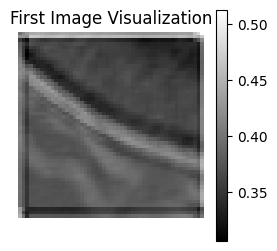

In [ ]:
import matplotlib.pyplot as plt

# Output 텐서 (torch.Size([16, 1, 51, 51]))
# 예: output 텐서가 존재한다고 가정
first_image = output[0, 0, :, :]  # 첫 번째 배치의 첫 번째 채널 선택

# 텐서를 NumPy 배열로 변환
first_image_np = first_image.detach().cpu().numpy()  # GPU 텐서일 경우 .cpu() 사용

# 시각화
plt.imshow(first_image_np, cmap='gray')
plt.colorbar()
plt.title("First Image Visualization")
plt.axis('off')
plt.show()

## 모델구현

2개의 attention을 앞단의 중간과 마지막 부분에 각각 설치

In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
class RedCNNWithSpatialAttention(nn.Module):
    def __init__(self):
        super(RedCNNWithSpatialAttention, self).__init__()

        # 인코더 부분
        self.conv1 = nn.Conv2d(1, 96, 5, 1, 0)
        self.conv2 = nn.Conv2d(96, 96, 5, 1, 0)
        self.conv3 = nn.Conv2d(96, 96, 5, 1, 0)
        self.conv4 = nn.Conv2d(96, 96, 5, 1, 0)
        self.conv5 = nn.Conv2d(96, 96, 5, 1, 0)

        # Spatial Attention Blocks
        self.spatial_attention3 = SpatialAttention()
        self.spatial_attention5 = SpatialAttention()

        # 디코더 부분
        self.deconv1 = nn.ConvTranspose2d(96, 96, 5, 1, 0)
        self.deconv2 = nn.ConvTranspose2d(96, 96, 5, 1, 0)
        self.deconv3 = nn.ConvTranspose2d(96, 96, 5, 1, 0)
        self.deconv4 = nn.ConvTranspose2d(96, 96, 5, 1, 0)
        self.deconv_last = nn.ConvTranspose2d(96, 1, 5, 1, 0)

        self.relu = nn.ReLU()

    def forward(self, x, prob):
        # 인코더 부분
        residual1 = x
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        residual2 = x
        x = self.relu(self.conv3(x))
        x = self.spatial_attention3(x, prob)  # Spatial Attention (3번째 위치)
        x = self.relu(self.conv4(x))
        residual3 = x
        x = self.relu(self.conv5(x))
        x = self.spatial_attention5(x, prob)  # Spatial Attention (5번째 위치)

        # 디코더 부분
        x = self.relu(self.deconv1(x) + residual3)
        x = self.relu(self.deconv2(x))
        x = self.relu(self.deconv3(x) + residual2)
        x = self.relu(self.deconv4(x))
        x = self.deconv_last(x) + residual1

        return x

In [ ]:
model = RedCNNWithSpatialAttention().to(device)
model


RedCNNWithSpatialAttention(
  (conv1): Conv2d(1, 96, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(96, 96, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(96, 96, kernel_size=(5, 5), stride=(1, 1))
  (conv4): Conv2d(96, 96, kernel_size=(5, 5), stride=(1, 1))
  (conv5): Conv2d(96, 96, kernel_size=(5, 5), stride=(1, 1))
  (spatial_attention3): SpatialAttention(
    (conv): Conv2d(2, 11, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    (sigmoid): Sigmoid()
  )
  (spatial_attention5): SpatialAttention(
    (conv): Conv2d(2, 11, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    (sigmoid): Sigmoid()
  )
  (deconv1): ConvTranspose2d(96, 96, kernel_size=(5, 5), stride=(1, 1))
  (deconv2): ConvTranspose2d(96, 96, kernel_size=(5, 5), stride=(1, 1))
  (deconv3): ConvTranspose2d(96, 96, kernel_size=(5, 5), stride=(1, 1))
  (deconv4): ConvTranspose2d(96, 96, kernel_size=(5, 5), stride=(1, 1))
  (deconv_last): ConvTranspose2d(96, 1, kernel_size=(5, 5), 

In [ ]:
%cd /content/drive/MyDrive

import utils.EarlyStopping
import utils.LRScheduler
import utils.train_eval_util
import importlib
importlib.reload(utils.EarlyStopping)
importlib.reload(utils.LRScheduler)
importlib.reload(utils.train_eval_util)

/content/drive/MyDrive


<module 'utils.train_eval_util' from '/content/drive/MyDrive/utils/train_eval_util.py'>

In [ ]:
import torch.nn as nn
criterion = nn.MSELoss()

from utils.EarlyStopping import *
from utils.LRScheduler import *
from utils.train_eval_util import train, evaluate

learning_rate = 1e-5
optimizer = torch.optim.Adam(params = model.parameters(),
                             lr = learning_rate)


early_stopping = EarlyStopping(patience = 7, # 7번까지는 개선이 안되어도 봐준다.
                               min_delta = 1e-5) # 이정도는 개선이 되어야한다. 아니면 위의 patience까지 count하다가 stop


scheduler = LRScheduler(optimizer = optimizer,
                        patience = 5,
                        min_lr = 1e-10,
                        factor = 0.5)

In [ ]:
first_batch = next(iter(train_loader))
(X,prob),y = first_batch
X.shape, prob.shape, y.shape

(torch.Size([16, 1, 55, 55]),
 torch.Size([16, 11]),
 torch.Size([16, 1, 55, 55]))

In [ ]:
len(first_batch[0])

2

In [ ]:
import torch
from tqdm import tqdm

interval = 1000

def train(model, train_loader, optimizer, criterion, device, epoch):
    model.train()
    running_loss = 0.0
    loss_list = []
    total_loss = 0.0  # ✅ 초기화

    for i, data in tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch} - Training"):
        X, prob, y = data[0][0].to(device), data[0][1].to(device), data[1].to(device)
        optimizer.zero_grad()
        X_hat = model(X, prob)
        loss = criterion(X_hat, y)
        loss.backward()
        optimizer.step()

        batch_loss = loss.item() * X.size(0)  # ✅ 배치별 손실 계산
        total_loss += batch_loss  # ✅ 모든 배치 손실 누적
        running_loss += batch_loss  # interval 내 손실 누적

        if i % interval == interval - 1:
            interval_loss = running_loss / interval
            loss_list.append(interval_loss)
            running_loss = 0.0
            tqdm.write(f'train loss : {interval_loss}')

    return loss_list, total_loss / len(train_loader.dataset)  # ✅ 평균 손실 반환

def evaluate(model, loader, criterion, device, epoch):
    model.eval()
    running_loss = 0.0
    loss_list = []
    total_loss = 0.0  # ✅ 초기화

    with torch.no_grad():
        for i, data in tqdm(enumerate(loader), total=len(loader), desc=f"Epoch {epoch} - Evaluating"):
            X, prob, y = data[0][0].to(device), data[0][1].to(device), data[1].to(device)
            X_hat = model(X, prob)
            loss = criterion(X_hat, y)

            batch_loss = loss.item() * X.size(0)  # ✅ 배치별 손실 계산
            total_loss += batch_loss  # ✅ 모든 배치 손실 누적
            running_loss += batch_loss  # interval 내 손실 누적

            if i % interval == interval - 1:
                interval_loss = running_loss / interval
                loss_list.append(interval_loss)
                running_loss = 0.0
                tqdm.write(f'val loss : {interval_loss}')

    return loss_list, total_loss / len(loader.dataset)  # ✅ 평균 손실 반환


# 학습

In [ ]:
!pwd

/content/drive/MyDrive


In [ ]:
%cd /content/drive/MyDrive/moanet

/content/drive/MyDrive/moanet


In [ ]:
epochs = 2 # 각 epoch마다 train(20분), valid(2분)이 소요된다.
best_valid_loss = float('inf')
train_loss_per_iter = []
train_loss_per_epoch = []
val_loss_per_iter = []
val_loss_per_epoch = []

for epoch in range(epochs):
    loss_list, total_loss = train(model, train_loader, optimizer, criterion, device, epoch)
    train_loss_per_iter.append(loss_list)
    train_loss_per_epoch.append(total_loss)

    loss_list, total_loss = evaluate(model, val_loader, criterion, device, epoch)
    val_loss_per_iter.append(loss_list)
    val_loss_per_epoch.append(total_loss)

    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss_per_epoch[-1]:.4f}, Valid Loss: {val_loss_per_epoch[-1]:.4f}")

    valid_loss = val_loss_per_epoch[-1]
    scheduler(valid_loss)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), "./" + 'moanet' + ".pth")
    if (early_stopping(valid_loss)):
        break

Epoch 0 - Training:   2%|▏         | 1011/57647 [00:12<11:23, 82.91it/s]

train loss : 0.0892576664313674


Epoch 0 - Training:   3%|▎         | 2009/57647 [00:24<11:32, 80.37it/s]

train loss : 0.05968296733312309


Epoch 0 - Training:   5%|▌         | 3015/57647 [00:36<11:09, 81.62it/s]

train loss : 0.055195986486971375


Epoch 0 - Training:   7%|▋         | 4014/57647 [00:48<10:42, 83.47it/s]

train loss : 0.05187888530269265


Epoch 0 - Training:   9%|▊         | 5008/57647 [01:00<10:50, 80.92it/s]

train loss : 0.0493968292158097


Epoch 0 - Training:  10%|█         | 6016/57647 [01:12<10:30, 81.88it/s]

train loss : 0.04857191094011069


Epoch 0 - Training:  12%|█▏        | 7020/57647 [01:22<07:48, 108.01it/s]

train loss : 0.046484641402959825


Epoch 0 - Training:  14%|█▍        | 8016/57647 [01:31<07:39, 107.93it/s]

train loss : 0.04612660114839673


Epoch 0 - Training:  16%|█▌        | 9012/57647 [01:41<07:36, 106.60it/s]

train loss : 0.045396976627409456


Epoch 0 - Training:  17%|█▋        | 10016/57647 [01:51<07:40, 103.44it/s]

train loss : 0.045606480665504934


Epoch 0 - Training:  19%|█▉        | 11013/57647 [02:00<07:35, 102.35it/s]

train loss : 0.04367366142943502


Epoch 0 - Training:  21%|██        | 12020/57647 [02:10<07:06, 106.86it/s]

train loss : 0.042977035062387585


Epoch 0 - Training:  23%|██▎       | 13018/57647 [02:19<07:19, 101.59it/s]

train loss : 0.043087313959375026


Epoch 0 - Training:  24%|██▍       | 14018/57647 [02:29<06:44, 107.74it/s]

train loss : 0.04228013616986573


Epoch 0 - Training:  26%|██▌       | 15019/57647 [02:38<06:47, 104.52it/s]

train loss : 0.04191523551940918


Epoch 0 - Training:  28%|██▊       | 16021/57647 [02:48<06:30, 106.48it/s]

train loss : 0.04166915626265109


Epoch 0 - Training:  30%|██▉       | 17010/57647 [02:57<06:30, 104.07it/s]

train loss : 0.041960012417286634


Epoch 0 - Training:  31%|███       | 18011/57647 [03:06<06:17, 104.92it/s]

train loss : 0.04122586202062666


Epoch 0 - Training:  33%|███▎      | 19011/57647 [03:16<06:09, 104.48it/s]

train loss : 0.04061154988780618


Epoch 0 - Training:  35%|███▍      | 20014/57647 [03:26<05:57, 105.16it/s]

train loss : 0.04072331849485636


Epoch 0 - Training:  36%|███▋      | 21015/57647 [03:35<05:45, 106.03it/s]

train loss : 0.04067386101186275


Epoch 0 - Training:  38%|███▊      | 22016/57647 [03:45<05:38, 105.42it/s]

train loss : 0.04064711963944137


Epoch 0 - Training:  40%|███▉      | 23016/57647 [03:54<05:27, 105.86it/s]

train loss : 0.039890222126618025


Epoch 0 - Training:  42%|████▏     | 24020/57647 [04:04<05:24, 103.67it/s]

train loss : 0.040205270932987335


Epoch 0 - Training:  43%|████▎     | 25021/57647 [04:13<05:09, 105.32it/s]

train loss : 0.03983048449270427


Epoch 0 - Training:  45%|████▌     | 26011/57647 [04:23<05:07, 103.01it/s]

train loss : 0.03927984864637256


Epoch 0 - Training:  47%|████▋     | 27012/57647 [04:32<04:48, 106.00it/s]

train loss : 0.03907579714246094


Epoch 0 - Training:  49%|████▊     | 28013/57647 [04:42<04:46, 103.39it/s]

train loss : 0.03934048433043063


Epoch 0 - Training:  50%|█████     | 29010/57647 [04:51<04:37, 103.37it/s]

train loss : 0.03950593862868845


Epoch 0 - Training:  52%|█████▏    | 30011/57647 [05:01<04:15, 108.18it/s]

train loss : 0.039252705607563255


Epoch 0 - Training:  54%|█████▍    | 31013/57647 [05:10<04:10, 106.20it/s]

train loss : 0.038701973164454104


Epoch 0 - Training:  56%|█████▌    | 32014/57647 [05:20<04:06, 103.91it/s]

train loss : 0.03899703067541122


Epoch 0 - Training:  57%|█████▋    | 33017/57647 [05:29<03:52, 105.75it/s]

train loss : 0.03889931964315474


Epoch 0 - Training:  59%|█████▉    | 34019/57647 [05:39<03:39, 107.76it/s]

train loss : 0.038427995393052694


Epoch 0 - Training:  61%|██████    | 35018/57647 [05:48<03:32, 106.38it/s]

train loss : 0.038865744529291986


Epoch 0 - Training:  62%|██████▏   | 36018/57647 [05:58<03:22, 106.77it/s]

train loss : 0.03804448592104018


Epoch 0 - Training:  64%|██████▍   | 37015/57647 [06:07<03:12, 107.01it/s]

train loss : 0.03844336913712323


Epoch 0 - Training:  66%|██████▌   | 38016/57647 [06:16<03:07, 104.66it/s]

train loss : 0.037898950949311255


Epoch 0 - Training:  68%|██████▊   | 39011/57647 [06:26<02:58, 104.64it/s]

train loss : 0.037950922153890135


Epoch 0 - Training:  69%|██████▉   | 40013/57647 [06:35<02:48, 104.89it/s]

train loss : 0.03838146591372788


Epoch 0 - Training:  71%|███████   | 41014/57647 [06:45<02:36, 106.06it/s]

train loss : 0.0381926554068923


Epoch 0 - Training:  73%|███████▎  | 42016/57647 [06:54<02:31, 103.05it/s]

train loss : 0.038463375678285956


Epoch 0 - Training:  75%|███████▍  | 43019/57647 [07:03<02:16, 107.31it/s]

train loss : 0.03821630373597145


Epoch 0 - Training:  76%|███████▋  | 44020/57647 [07:13<02:08, 106.00it/s]

train loss : 0.03797042555734515


Epoch 0 - Training:  78%|███████▊  | 45021/57647 [07:23<02:02, 102.75it/s]

train loss : 0.037762048799544576


Epoch 0 - Training:  80%|███████▉  | 46011/57647 [07:32<01:54, 101.54it/s]

train loss : 0.03741462380811572


Epoch 0 - Training:  82%|████████▏ | 47012/57647 [07:42<01:43, 102.39it/s]

train loss : 0.03733422769978643


Epoch 0 - Training:  83%|████████▎ | 48018/57647 [07:51<01:30, 106.57it/s]

train loss : 0.03793460265733302


Epoch 0 - Training:  85%|████████▌ | 49019/57647 [08:01<01:23, 103.55it/s]

train loss : 0.0373836749792099


Epoch 0 - Training:  87%|████████▋ | 50020/57647 [08:10<01:11, 106.57it/s]

train loss : 0.03734470116905868


Epoch 0 - Training:  89%|████████▊ | 51021/57647 [08:20<01:02, 106.46it/s]

train loss : 0.03655146643519402


Epoch 0 - Training:  90%|█████████ | 52012/57647 [08:29<00:53, 105.53it/s]

train loss : 0.036834420455619694


Epoch 0 - Training:  92%|█████████▏| 53012/57647 [08:39<00:43, 107.71it/s]

train loss : 0.037399934062734244


Epoch 0 - Training:  94%|█████████▎| 54014/57647 [08:48<00:34, 105.26it/s]

train loss : 0.03645782873593271


Epoch 0 - Training:  95%|█████████▌| 55016/57647 [08:58<00:24, 105.63it/s]

train loss : 0.03655385746248067


Epoch 0 - Training:  97%|█████████▋| 56012/57647 [09:07<00:15, 103.46it/s]

train loss : 0.03674705088324845


Epoch 0 - Training:  99%|█████████▉| 57013/57647 [09:17<00:05, 105.74it/s]

train loss : 0.037291622042655945


Epoch 0 - Evaluating:  22%|██▏       | 1041/4815 [00:03<00:13, 286.56it/s]

val loss : 0.04313341858331114


Epoch 0 - Evaluating:  42%|████▏     | 2041/4815 [00:06<00:09, 303.43it/s]

val loss : 0.046852896097116174


Epoch 0 - Evaluating:  63%|██████▎   | 3051/4815 [00:10<00:06, 292.30it/s]

val loss : 0.03078112881188281


Epoch 0 - Evaluating:  84%|████████▍ | 4049/4815 [00:13<00:02, 291.19it/s]

val loss : 0.03431698160152882


Epoch 0 - Evaluating: 100%|██████████| 4815/4815 [00:17<00:00, 273.67it/s]

Epoch [1/2], Train Loss: 0.0026, Valid Loss: 0.0023



Epoch 1 - Training:   2%|▏         | 1015/57647 [00:12<11:05, 85.14it/s]

train loss : 0.03715534097701311


Epoch 1 - Training:   3%|▎         | 2009/57647 [00:24<11:05, 83.58it/s]

train loss : 0.03702214745245874


Epoch 1 - Training:   5%|▌         | 3008/57647 [00:36<10:56, 83.29it/s]

train loss : 0.03691600193269551


Epoch 1 - Training:   7%|▋         | 4016/57647 [00:48<10:53, 82.11it/s]

train loss : 0.03666067325696349


Epoch 1 - Training:   9%|▊         | 5015/57647 [01:00<10:30, 83.43it/s]

train loss : 0.036781809348613026


Epoch 1 - Training:  10%|█         | 6014/57647 [01:12<10:19, 83.39it/s]

train loss : 0.03605460451543331


Epoch 1 - Training:  12%|█▏        | 7011/57647 [01:22<07:57, 106.07it/s]

train loss : 0.03703748829104006


Epoch 1 - Training:  14%|█▍        | 8012/57647 [01:32<08:02, 102.79it/s]

train loss : 0.03623982965387404


Epoch 1 - Training:  16%|█▌        | 9012/57647 [01:41<07:28, 108.49it/s]

train loss : 0.036821338230744


Epoch 1 - Training:  17%|█▋        | 10015/57647 [01:51<07:23, 107.29it/s]

train loss : 0.03643666165415198


Epoch 1 - Training:  19%|█▉        | 11019/57647 [02:00<07:12, 107.79it/s]

train loss : 0.036450529795140026


Epoch 1 - Training:  21%|██        | 12020/57647 [02:09<07:05, 107.19it/s]

train loss : 0.03666519574820995


Epoch 1 - Training:  23%|██▎       | 13015/57647 [02:19<06:48, 109.16it/s]

train loss : 0.03637999516353011


Epoch 1 - Training:  24%|██▍       | 14018/57647 [02:28<06:57, 104.49it/s]

train loss : 0.03698661571741104


Epoch 1 - Training:  26%|██▌       | 15021/57647 [02:38<06:55, 102.65it/s]

train loss : 0.03694365411903709


Epoch 1 - Training:  28%|██▊       | 16012/57647 [02:47<06:23, 108.43it/s]

train loss : 0.03625707756541669


Epoch 1 - Training:  30%|██▉       | 17016/57647 [02:57<06:40, 101.37it/s]

train loss : 0.03585675931163132


Epoch 1 - Training:  31%|███▏      | 18017/57647 [03:06<06:25, 102.71it/s]

train loss : 0.03599351142160594


Epoch 1 - Training:  33%|███▎      | 19019/57647 [03:16<06:06, 105.28it/s]

train loss : 0.03549181229434908


Epoch 1 - Training:  35%|███▍      | 20020/57647 [03:25<06:03, 103.38it/s]

train loss : 0.03609586610086262


Epoch 1 - Training:  36%|███▋      | 21011/57647 [03:35<05:48, 105.19it/s]

train loss : 0.03602313902787864


Epoch 1 - Training:  38%|███▊      | 22013/57647 [03:44<05:37, 105.61it/s]

train loss : 0.03605953017622233


Epoch 1 - Training:  40%|███▉      | 23013/57647 [03:54<05:25, 106.47it/s]

train loss : 0.036141026468947526


Epoch 1 - Training:  42%|████▏     | 24017/57647 [04:03<05:32, 101.05it/s]

train loss : 0.036294271004386244


Epoch 1 - Training:  43%|████▎     | 25019/57647 [04:13<05:05, 106.70it/s]

train loss : 0.03609509866684675


Epoch 1 - Training:  45%|████▌     | 26020/57647 [04:22<04:56, 106.73it/s]

train loss : 0.03574710970744491


Epoch 1 - Training:  47%|████▋     | 27021/57647 [04:32<04:45, 107.31it/s]

train loss : 0.035871483344584704


Epoch 1 - Training:  49%|████▊     | 28012/57647 [04:41<04:36, 107.05it/s]

train loss : 0.036209189033135775


Epoch 1 - Training:  50%|█████     | 29017/57647 [04:51<04:30, 105.74it/s]

train loss : 0.03542796645872295


Epoch 1 - Training:  52%|█████▏    | 30014/57647 [05:00<04:23, 104.73it/s]

train loss : 0.0355356575269252


Epoch 1 - Training:  54%|█████▍    | 31017/57647 [05:10<04:12, 105.37it/s]

train loss : 0.035926082979887725


Epoch 1 - Training:  56%|█████▌    | 32018/57647 [05:19<03:57, 107.86it/s]

train loss : 0.03540932589396834


Epoch 1 - Training:  57%|█████▋    | 33019/57647 [05:29<03:47, 108.41it/s]

train loss : 0.03541973497159779


Epoch 1 - Training:  59%|█████▉    | 34019/57647 [05:38<03:44, 105.41it/s]

train loss : 0.03594710812717676


Epoch 1 - Training:  61%|██████    | 35020/57647 [05:48<03:37, 104.12it/s]

train loss : 0.035915143832564354


Epoch 1 - Training:  62%|██████▏   | 36010/57647 [05:57<03:32, 101.86it/s]

train loss : 0.0359751163572073


Epoch 1 - Training:  64%|██████▍   | 37011/57647 [06:07<03:14, 105.98it/s]

train loss : 0.03538797882944345


Epoch 1 - Training:  66%|██████▌   | 38012/57647 [06:16<03:14, 101.08it/s]

train loss : 0.03650374584272504


Epoch 1 - Training:  68%|██████▊   | 39021/57647 [06:26<02:54, 106.44it/s]

train loss : 0.03560289680585265


Epoch 1 - Training:  69%|██████▉   | 40011/57647 [06:35<02:47, 105.06it/s]

train loss : 0.03555406936816871


Epoch 1 - Training:  71%|███████   | 41012/57647 [06:44<02:39, 103.98it/s]

train loss : 0.03603940872661769


Epoch 1 - Training:  73%|███████▎  | 42013/57647 [06:54<02:30, 103.77it/s]

train loss : 0.035828383719548586


Epoch 1 - Training:  75%|███████▍  | 43012/57647 [07:04<02:17, 106.58it/s]

train loss : 0.03558111909404397


Epoch 1 - Training:  76%|███████▋  | 44018/57647 [07:13<02:14, 101.33it/s]

train loss : 0.03580670019052923


Epoch 1 - Training:  78%|███████▊  | 45018/57647 [07:23<02:09, 97.85it/s]

train loss : 0.03582939589954913


Epoch 1 - Training:  80%|███████▉  | 46018/57647 [07:32<01:48, 107.16it/s]

train loss : 0.03544981460645795


Epoch 1 - Training:  82%|████████▏ | 47019/57647 [07:42<01:42, 104.15it/s]

train loss : 0.035330551788210866


Epoch 1 - Training:  83%|████████▎ | 48020/57647 [07:52<01:31, 105.27it/s]

train loss : 0.036333629198372366


Epoch 1 - Training:  85%|████████▌ | 49021/57647 [08:01<01:19, 107.88it/s]

train loss : 0.035401581190526485


Epoch 1 - Training:  87%|████████▋ | 50011/57647 [08:10<01:11, 106.90it/s]

train loss : 0.03545769382454455


Epoch 1 - Training:  89%|████████▊ | 51018/57647 [08:20<01:02, 105.96it/s]

train loss : 0.03533106497488916


Epoch 1 - Training:  90%|█████████ | 52020/57647 [08:29<00:53, 105.49it/s]

train loss : 0.03594212907925248


Epoch 1 - Training:  92%|█████████▏| 53021/57647 [08:39<00:43, 107.14it/s]

train loss : 0.035323580006137494


Epoch 1 - Training:  94%|█████████▎| 54012/57647 [08:48<00:34, 104.85it/s]

train loss : 0.03537675005197525


Epoch 1 - Training:  95%|█████████▌| 55013/57647 [08:58<00:25, 105.11it/s]

train loss : 0.03517581344023347


Epoch 1 - Training:  97%|█████████▋| 56010/57647 [09:07<00:15, 104.73it/s]

train loss : 0.03557911883387715


Epoch 1 - Training:  99%|█████████▉| 57014/57647 [09:17<00:06, 103.67it/s]

train loss : 0.03513668749108911


Epoch 1 - Evaluating:  21%|██▏       | 1032/4815 [00:03<00:13, 285.78it/s]

val loss : 0.041635542090050874


Epoch 1 - Evaluating:  43%|████▎     | 2049/4815 [00:07<00:09, 296.80it/s]

val loss : 0.044538482898846266


Epoch 1 - Evaluating:  63%|██████▎   | 3037/4815 [00:10<00:06, 281.04it/s]

val loss : 0.0296345048584044


Epoch 1 - Evaluating:  84%|████████▍ | 4034/4815 [00:14<00:02, 287.36it/s]

val loss : 0.03301037167385221


Epoch 1 - Evaluating: 100%|██████████| 4815/4815 [00:17<00:00, 268.38it/s]

Epoch [2/2], Train Loss: 0.0023, Valid Loss: 0.0022


In [ ]:
import pickle

data_to_save = {
    'train_loss_per_iter': train_loss_per_iter,
    'val_loss_per_iter': val_loss_per_iter,
    'train_loss_per_epoch': train_loss_per_epoch,
    'val_loss_per_epoch': val_loss_per_epoch
}

for filename, data in data_to_save.items():
    with open(f'{filename}.pkl', 'wb') as f:
        pickle.dump(data, f)

In [ ]:
import pickle

filenames = [
    'train_loss_per_iter.pkl',
    'val_loss_per_iter.pkl',
    'train_loss_per_epoch.pkl',
    'val_loss_per_epoch.pkl'
]

variables = [
    'train_loss_per_iter',
    'val_loss_per_iter',
    'train_loss_per_epoch',
    'val_loss_per_epoch'
]

data_to_load = dict(zip(filenames, variables))

for filename, variable_name in data_to_load.items():
    with open(filename, 'rb') as f:
        globals()[variable_name] = pickle.load(f)

In [ ]:
train_flatten, val_flatten = [item for sublist in train_loss_per_iter for item in sublist], [item for sublist in val_loss_per_iter for item in sublist]

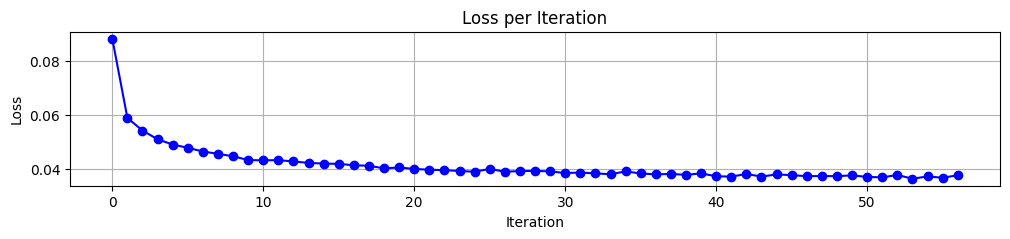

In [ ]:
plt.figure(figsize=(12, 2))

# 반복 단위 손실 그래프
plt.plot(train_flatten, label='Train (per iter)', linestyle='-', marker='o', color='blue')
plt.title("Loss per Iteration")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.grid()
plt.show()

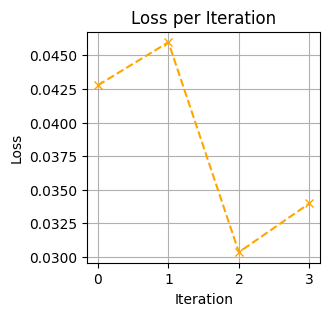

In [ ]:
plt.plot(val_flatten, label='Validation (per iter)', linestyle='--', marker='x', color='orange')
plt.title("Loss per Iteration")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.grid()
plt.show()

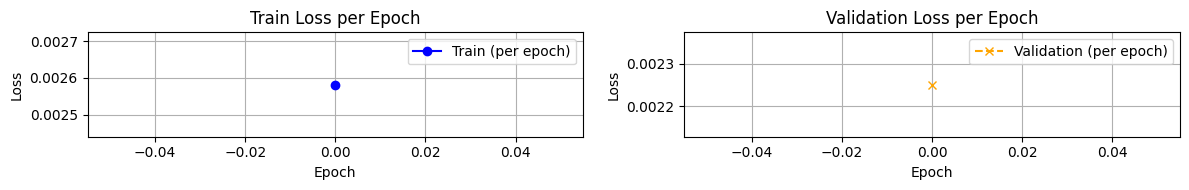

In [ ]:
# 1행 2열 레이아웃 생성
fig, axes = plt.subplots(1, 2, figsize=(12, 2))  # 그래프 크기 조정

# Train loss per epoch 그래프
axes[0].plot(train_loss_per_epoch, label='Train (per epoch)', linestyle='-', marker='o', color='blue')
axes[0].set_title("Train Loss per Epoch")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].grid()
axes[0].legend()

# Validation loss per epoch 그래프
axes[1].plot(val_loss_per_epoch, label='Validation (per epoch)', linestyle='--', marker='x', color='orange')
axes[1].set_title("Validation Loss per Epoch")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss")
axes[1].grid()
axes[1].legend()

plt.tight_layout()
plt.show()

# 평가

In [ ]:
!pwd

/content/drive/MyDrive/moanet


In [ ]:
%cd /content/drive/MyDrive/moanet

/content/drive/MyDrive/moanet


In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## batch size 16

### loss 추이 관찰

In [ ]:
criterion = nn.MSELoss()
interval = 1000

# 저장된 모델 로드
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RedCNNWithSpatialAttention().to(device)
model.load_state_dict(torch.load('moanet.pth'))

<All keys matched successfully>

In [ ]:
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4, pin_memory=True)
len(test_loader)

6025

In [ ]:
# evaluate부분 + top10 best&worst
model.eval()
running_loss = 0.0
loss_list = []
total_loss = 0
best_loss = np.inf
worst_loss = -np.inf

with torch.no_grad():
    for i, data in tqdm(enumerate(test_loader), total=len(test_loader), desc=f"Evaluating"):
        X, prob, y = data[0][0].to(device), data[0][1].to(device), data[1].to(device)
        X_hat = model(X, prob)
        loss = criterion(X_hat, y)

        if loss < best_loss:
            best_loss = loss
            best = (X,y,X_hat)
        if loss > worst_loss:
            worst_loss = loss
            worst = (X,y,X_hat)

        running_loss += loss.item() * X.size(0)

        if i % interval == interval-1:
            interval_loss = running_loss / interval
            loss_list.append(interval_loss)
            total_loss += running_loss
            running_loss = 0.0
            tqdm.write(f'train loss : {interval_loss}')

Evaluating:  17%|█▋        | 1047/6025 [00:03<00:17, 279.41it/s]

train loss : 0.037537226264365016


Evaluating:  34%|███▍      | 2037/6025 [00:07<00:14, 274.17it/s]

train loss : 0.03425372052751482


Evaluating:  51%|█████     | 3051/6025 [00:10<00:10, 284.72it/s]

train loss : 0.03567821500520222


Evaluating:  67%|██████▋   | 4053/6025 [00:14<00:07, 276.41it/s]

train loss : 0.02515142559958622


Evaluating:  84%|████████▎ | 5044/6025 [00:18<00:03, 271.10it/s]

train loss : 0.024658151616109535


Evaluating: 100%|█████████▉| 6016/6025 [00:21<00:00, 287.64it/s]

train loss : 0.022542076656594873


Evaluating: 100%|██████████| 6025/6025 [00:23<00:00, 260.94it/s]


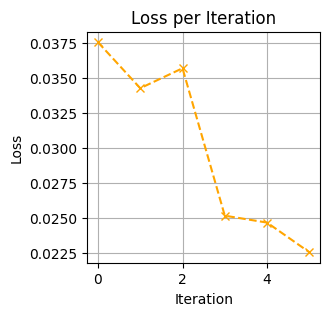

In [ ]:
plt.plot(loss_list, label='Test', linestyle='--', marker='x', color='orange')
plt.title("Loss per Iteration")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.grid()
plt.show()

### 16개 개별비교

In [ ]:
def visualize_patches_total(X, y, X_hat):

    fig, axes = plt.subplots(3, 16, figsize=(32, 6))  # 3행 16열로 설정
    fig.suptitle("Patches", fontsize=12, y=1.05)  # 전체 제목 추가

    for i in range(X.shape[0]):  # 16개의 이미지만큼 반복
        # X 데이터 시각화
        axes[0, i].imshow(X[i], cmap='gray', vmin=-200, vmax=300)
        axes[0, i].axis('off')
        axes[0, i].set_title(f"X {i+1}", fontsize=12)

        # y 데이터 시각화
        axes[1, i].imshow(y[i], cmap='gray', vmin=-200, vmax=300)
        axes[1, i].axis('off')
        axes[1, i].set_title(f"y {i+1}", fontsize=12)

        # X_hat 데이터 시각화
        axes[2, i].imshow(X_hat[i], cmap='gray', vmin=-200, vmax=300)
        axes[2, i].axis('off')
        axes[2, i].set_title(f"X_hat {i+1}", fontsize=12)

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)  # 제목 위치 조정
    plt.show()


In [ ]:
# 1. 랜덤비교

test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=0)
test_iter = iter(test_loader)
len(test_iter)

6025

In [ ]:
idx = 400 # 1~6025 여기 안에서 선택
for i in range(idx):
    (X_test,prob), y_test = next(test_iter)

In [ ]:
prob.shape

torch.Size([81, 11])

In [ ]:
X = np.squeeze(X_test.cpu().numpy()) * 500 - 500
y = np.squeeze(y_test.cpu().numpy()) * 500 - 500
X_hat = np.squeeze(model(X_test.cuda(),prob.cuda()).cpu().detach()).numpy() * 500 - 500

In [ ]:
X.shape, y.shape, X_hat.shape

((16, 55, 55), (16, 55, 55), (16, 55, 55))

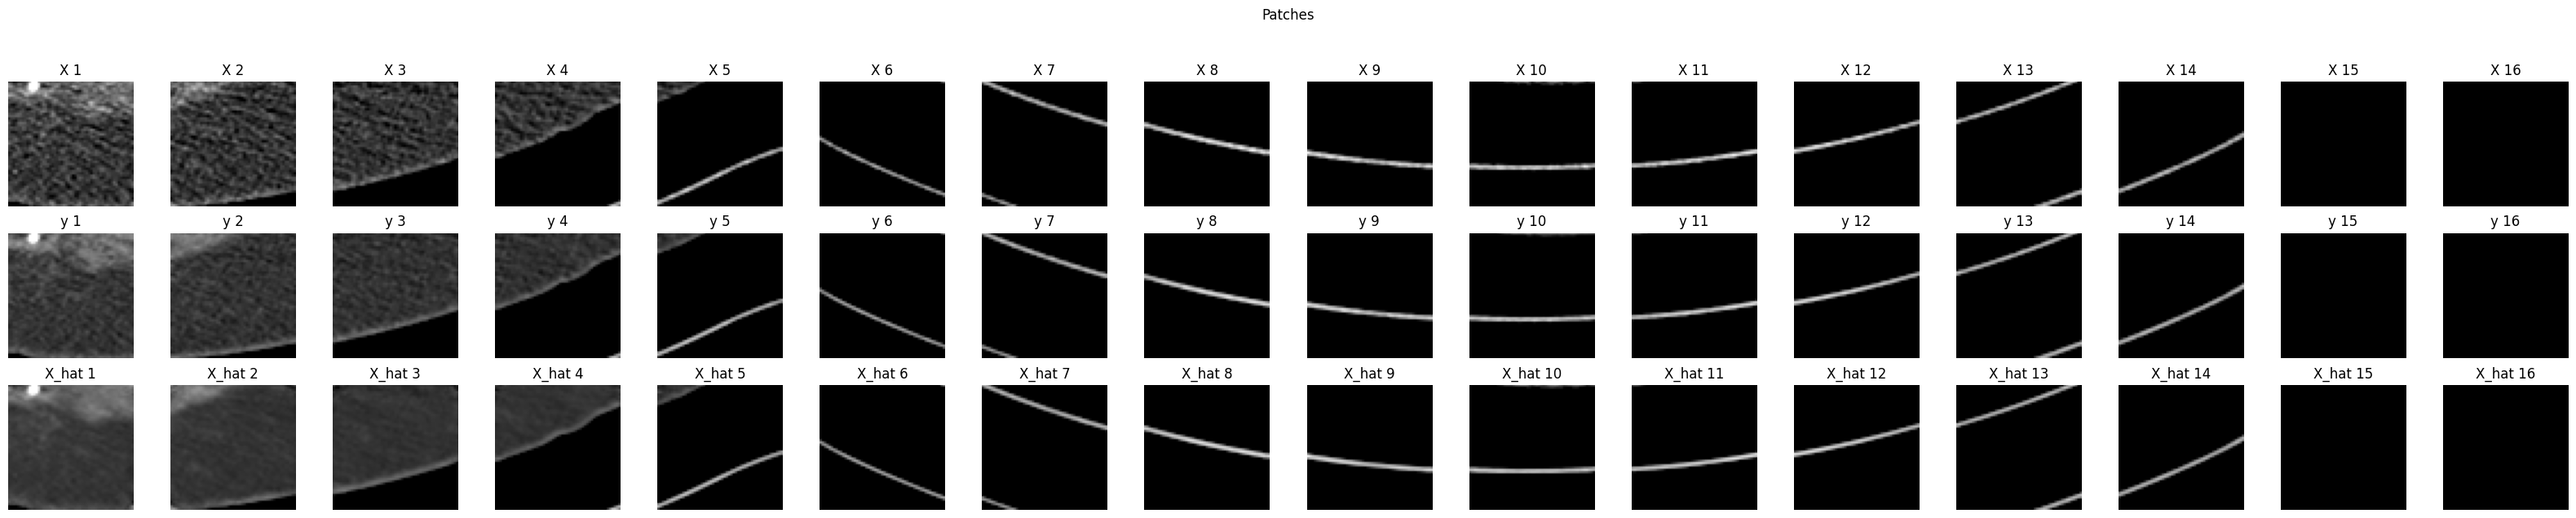

In [ ]:
visualize_patches_total(X, y, X_hat)

In [ ]:
# 2. 가장 loss가 낮은 값 확인

X_test,y_test,X_hat = best

X = np.squeeze(X_test.cpu().numpy()) * 500 - 500
y = np.squeeze(y_test.cpu().numpy()) * 500 - 500
X_hat = np.squeeze(X_hat.cpu().numpy()) * 500 - 500

In [ ]:
X.shape, y.shape, X_hat.shape

((16, 55, 55), (16, 55, 55), (16, 55, 55))

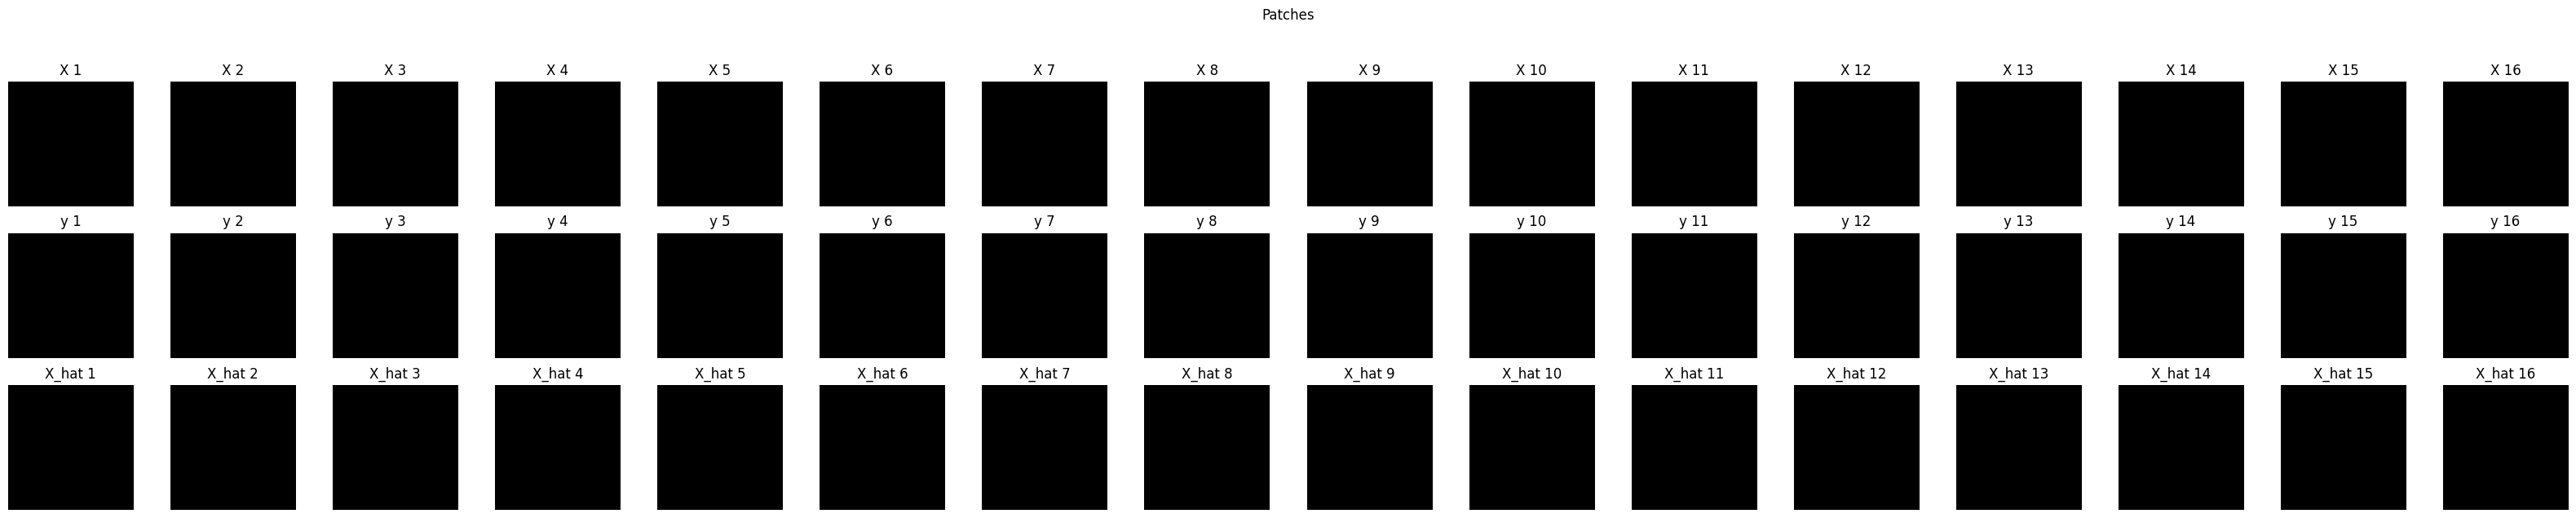

In [ ]:
visualize_patches_total(X, y, X_hat)

In [ ]:
# 3. 가장 loss가 높은 값 확인

X_test,y_test,X_hat = worst

X = np.squeeze(X_test.cpu().numpy()) * 500 - 500
y = np.squeeze(y_test.cpu().numpy()) * 500 - 500
X_hat = np.squeeze(X_hat.cpu().numpy()) * 500 - 500

In [ ]:
X.shape, y.shape, X_hat.shape

((16, 55, 55), (16, 55, 55), (16, 55, 55))

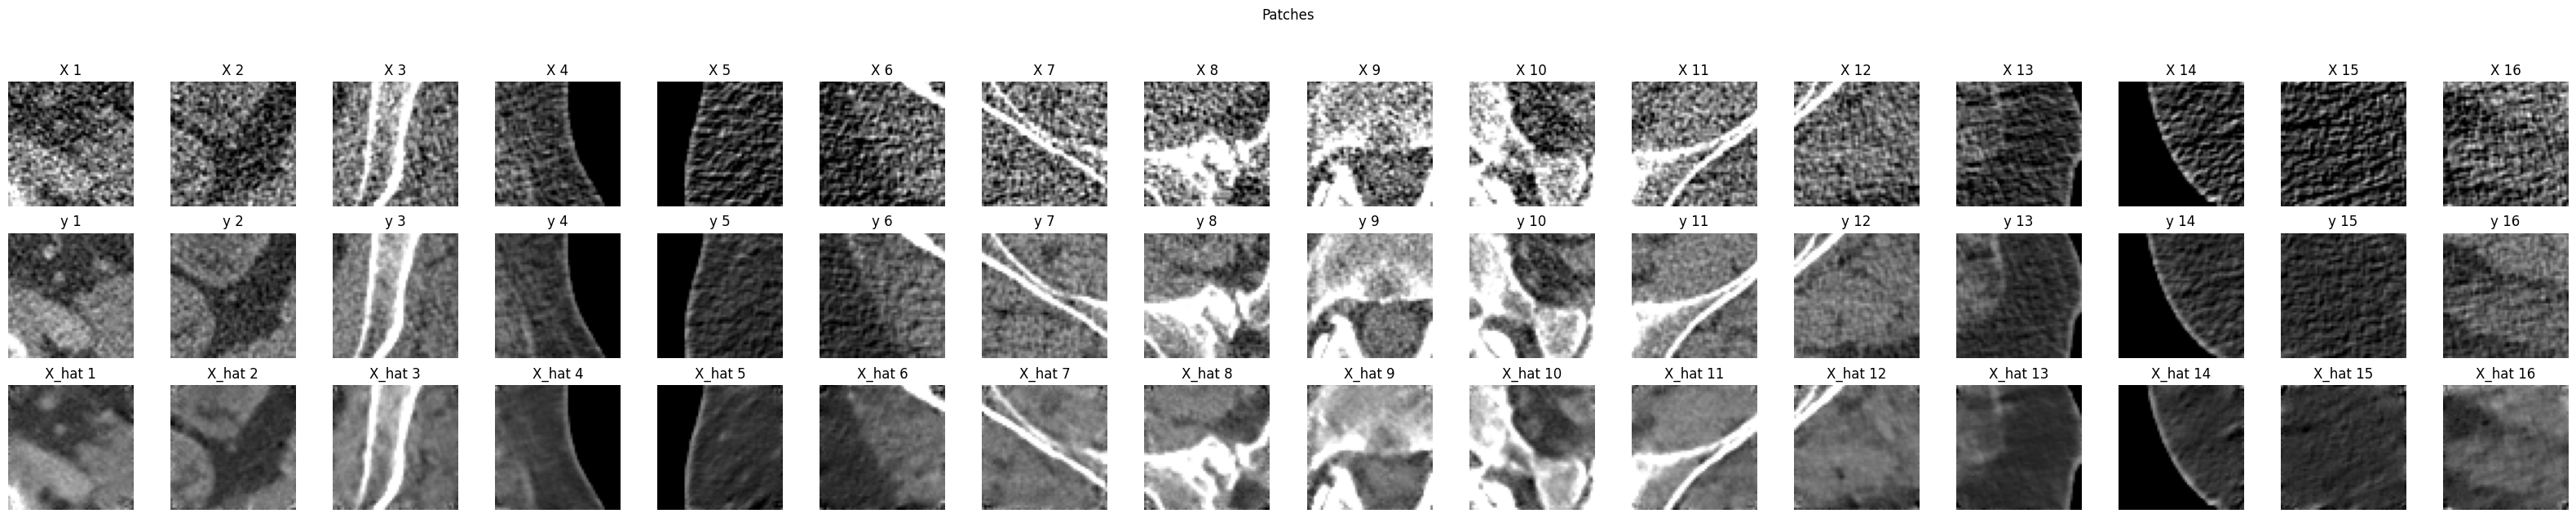

In [ ]:
visualize_patches_total(X, y, X_hat)

## batch size = 81

In [ ]:
criterion = nn.MSELoss()
interval = 1000

# 저장된 모델 로드
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RedCNNWithSpatialAttention().to(device)
model.load_state_dict(torch.load('moanet.pth'))

<All keys matched successfully>

In [ ]:
test_loader = DataLoader(test_dataset, batch_size=81, shuffle=False, num_workers=4, pin_memory=True)
len(test_loader)

1190

In [ ]:
# evaluate부분 + top10 best&worst
model.eval()
running_loss = 0.0
loss_list = []
total_loss = 0
best_loss = np.inf
worst_loss = -np.inf

with torch.no_grad():
    for i, data in tqdm(enumerate(test_loader), total=len(test_loader), desc=f"Evaluating"):
        X, prob, y = data[0][0].to(device), data[0][1].to(device), data[1].to(device)
        X_hat = model(X, prob)
        loss = criterion(X_hat, y)

        if loss < best_loss:
            best_loss = loss
            best = (X,y,X_hat)
        if loss > worst_loss:
            worst_loss = loss
            worst = (X,y,X_hat)

        running_loss += loss.item() * X.size(0)

        if i % interval == interval-1:
            interval_loss = running_loss / interval
            loss_list.append(interval_loss)
            total_loss += running_loss
            running_loss = 0.0
            tqdm.write(f'train loss : {interval_loss}')

Evaluating:  85%|████████▌ | 1015/1190 [00:13<00:02, 76.40it/s]

train loss : 0.15899557618412655


Evaluating: 100%|██████████| 1190/1190 [00:16<00:00, 70.26it/s]


### 함수정의

In [ ]:
def reconstruct_image(prediction, num_patches_per_row=9, patch_size=55):
    # prediction: (81, 1, 55, 55) 크기의 torch 텐서
    num_patches = prediction.shape[0]  # 81개의 패치
    assert prediction.shape == (81, 1, 55, 55) # "패치의 크기가 올바르지 않습니다."

    # 최종적으로 1x495x495 크기의 이미지를 만들기 위한 초기화
    final_image = torch.zeros(1, num_patches_per_row * patch_size, num_patches_per_row * patch_size)

    # 9x9 배열로 패치 붙이기
    for i in range(num_patches):
        row = i // num_patches_per_row  # 현재 패치의 행 번호
        col = i % num_patches_per_row   # 현재 패치의 열 번호

        # 패치를 해당 위치에 붙이기
        final_image[:,
                    row * patch_size:(row + 1) * patch_size,
                    col * patch_size:(col + 1) * patch_size] = prediction[i, 0]

    return final_image

In [ ]:
def extract_patches(img, patch_size=55, interval=55):
    patches = []
    _, height, width = img.shape
    for y in range(0, height - patch_size + 1, interval):
        for x in range(0, width - patch_size + 1, interval):
            patch = img[:, y:y + patch_size, x:x + patch_size]
            patches.append(patch)
    patches = torch.stack(patches)  # 리스트를 텐서로 변환
    return patches  # 반환 형태는 patch 수 x 1 x 55 x 55

In [ ]:
def rescale(img):
    return img*500-500 # -1000부터 2000의 값으로 다시 변환

In [ ]:
def trans_img(X):
    return rescale(np.squeeze(reconstruct_image(X)))

In [ ]:
X_test,y_test,X_hat = best
trans_img(X_test).min(), trans_img(X_test).max()

(tensor(-1024.), tensor(1862.))

In [ ]:
!pwd

/content/drive/MyDrive/moanet


In [ ]:
def save_img(X_test, X_hat, y_test, s):
    # X_test 저장
    numpy_X_test = trans_img(X_test).numpy()
    np.save(f'X_test_image{s}.npy', numpy_X_test)

    # X_hat 저장
    numpy_X_hat = trans_img(X_hat).numpy()
    np.save(f'X_hat_image{s}.npy', numpy_X_hat)

    # y_test 저장
    numpy_y_test = trans_img(y_test).numpy()
    np.save(f'y_test_image{s}.npy', numpy_y_test)

### 1. best

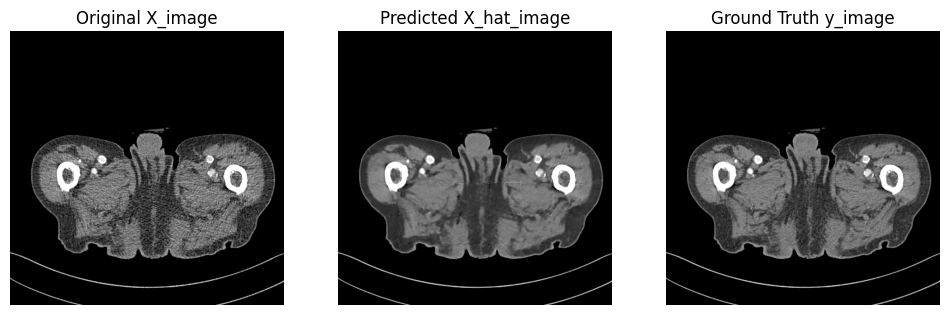

In [ ]:
# 1. 가장 좋은 값 가져오기
X_test,y_test,X_hat = best

# 세 개의 이미지를 한 줄에 그리기
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# X_image 표시
axes[0].imshow(trans_img(X_test), cmap='gray', vmin=-200, vmax=300)
axes[0].set_title("Original X_image")
axes[0].axis('off')  # 축 숨기기

# X_hat_image 표시
axes[1].imshow(trans_img(X_hat), cmap='gray', vmin=-200, vmax=300)
axes[1].set_title("Predicted X_hat_image")
axes[1].axis('off')  # 축 숨기기

# y_image 표시
axes[2].imshow(trans_img(y_test), cmap='gray', vmin=-200, vmax=300)
axes[2].set_title("Ground Truth y_image")
axes[2].axis('off')  # 축 숨기기

# 이미지 보여주기
plt.show()

In [ ]:
# 이미지 저장

save_img(X_test, X_hat, y_test, 'best')

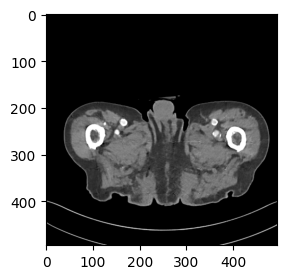

In [ ]:
# 불러오기

import numpy as np

s = 'best'
X_test = np.load(f'X_hat_image{s}.npy')

plt.imshow(X_test, cmap='gray', vmin=-200, vmax=300)

### 2. worst

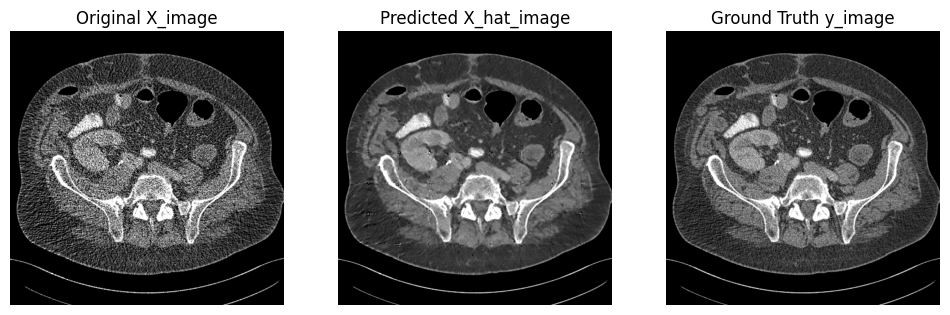

In [ ]:
# 2. 가장 나쁜 값 가져오기
X_test,y_test,X_hat = worst

# 세 개의 이미지를 한 줄에 그리기
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# X_image 표시
axes[0].imshow(trans_img(X_test), cmap='gray', vmin=-200, vmax=300)
axes[0].set_title("Original X_image")
axes[0].axis('off')  # 축 숨기기

# X_hat_image 표시
axes[1].imshow(trans_img(X_hat), cmap='gray', vmin=-200, vmax=300)
axes[1].set_title("Predicted X_hat_image")
axes[1].axis('off')  # 축 숨기기

# y_image 표시
axes[2].imshow(trans_img(y_test), cmap='gray', vmin=-200, vmax=300)
axes[2].set_title("Ground Truth y_image")
axes[2].axis('off')  # 축 숨기기

# 이미지 보여주기
plt.show()

In [ ]:
# 이미지 저장

save_img(X_test, X_hat, y_test, 'worst')

### 3. 랜덤

In [ ]:
import glob
# 3. 랜덤선택

i,j = 0,0
X_dir = sorted(glob.glob(f'{root}/mayo2016/{L_list[i]}/{data_label[0]}/*.IMA'))[j]
y_dir = sorted(glob.glob(f'{root}/mayo2016/{L_list[i]}/{data_label[1]}/*.IMA'))[j]

X_image, y_image = normlize(X_dir), normlize(y_dir)
X_patches = extract_patches(torch.from_numpy(X_image))

X_image.shape, y_image.shape, X_patches.shape

((1, 512, 512), (1, 512, 512), torch.Size([81, 1, 55, 55]))

In [ ]:
import torch
from PIL import Image
from urllib.request import urlopen
from open_clip import create_model_from_pretrained, get_tokenizer

# 모델 및 전처리기 로드
model_name = 'hf-hub:microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224'
clip_model, preprocess = create_model_from_pretrained(model_name)
tokenizer = get_tokenizer(model_name)

# 모델을 평가 모드로 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
clip_model.to(device)
clip_model.eval()

# 사용할 이미지
dicom_img = load_dicom_image(X_dir)
image_tensor = preprocess(dicom_img).unsqueeze(0).to(device)
text_tokens = tokenizer(text_descriptions).to(device)

# 이미지 및 텍스트 전처리
image_input = preprocess(image).unsqueeze(0).to(device)
text_input = tokenizer(texts).to(device)

# 예측 수행
with torch.no_grad():
    image_features, text_features, logit_scale = clip_model(image_input, text_tokens)
    logits = (logit_scale * image_features @ text_features.T).softmax(dim=-1)

In [ ]:
prob.shape

torch.Size([81, 11])

In [ ]:
logits.shape

torch.Size([1, 11])

In [ ]:
X_patches.shape

torch.Size([81, 1, 55, 55])

In [ ]:
expanded_logits = logits.expand(81, -1)  # shape: [81, 11]
expanded_logits.shape

torch.Size([81, 11])

In [ ]:
X_hat = model(X_patches.cuda(),expanded_logits.cuda())
X_hat.shape

torch.Size([81, 1, 55, 55])

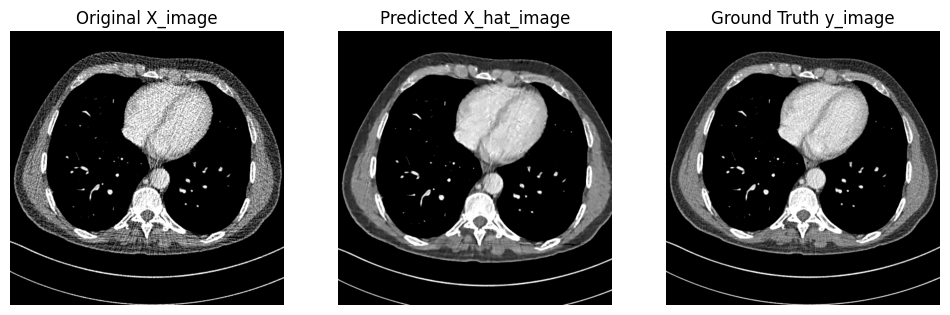

In [ ]:
# 세 개의 이미지를 한 줄에 그리기
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# X_image 표시
axes[0].imshow(rescale(np.squeeze(X_image)), cmap='gray', vmin=-200, vmax=300)
axes[0].set_title("Original X_image")
axes[0].axis('off')  # 축 숨기기

# X_hat_image 표시
axes[1].imshow(rescale(np.squeeze(reconstruct_image(X_hat.detach().cpu()))), cmap='gray', vmin=-200, vmax=300)
axes[1].set_title("Predicted X_hat_image")
axes[1].axis('off')  # 축 숨기기

# y_image 표시
axes[2].imshow(rescale(np.squeeze(y_image)), cmap='gray', vmin=-200, vmax=300)
axes[2].set_title("Ground Truth y_image")
axes[2].axis('off')  # 축 숨기기

# 이미지 보여주기
plt.show()

In [ ]:
!pwd

/content/drive/MyDrive/moanet


In [ ]:
def recreat(X_dir):

    # X_patches
    X_img = normlize(X_dir)
    X_patches = extract_patches(torch.from_numpy(X_img))
    # prob
    dicom_img = load_dicom_image(X_dir)
    image_tensor = preprocess(dicom_img).unsqueeze(0).to(device)
    text_tokens = tokenizer(text_descriptions).to(device)
    image_input = preprocess(image).unsqueeze(0).to(device)
    text_input = tokenizer(texts).to(device)
    with torch.no_grad():
        image_features, text_features, logit_scale = clip_model(image_input, text_tokens)
        logits = (logit_scale * image_features @ text_features.T).softmax(dim=-1)
    expanded_logits = logits.expand(81, -1)
    # X_hat
    X_hat = model(X_patches.cuda(),expanded_logits.cuda())

    return reconstruct_image(X_hat.detach().cpu())

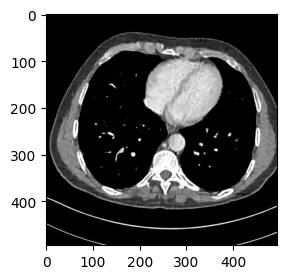

In [ ]:
plt.imshow(rescale(np.squeeze(recreat(X_dir))), cmap='gray', vmin=-200, vmax=300)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

i, n = 0, 10
L = L_list[i]

# 전체 이미지 배열을 생성
fig, axes = plt.subplots(n, 3, figsize=(12, 4 * n))

for i in range(n):
    X_dir = sorted(glob.glob(f'{root}/mayo2016/{L_list[i]}/{data_label[0]}/*.IMA'))[j]
    y_dir = sorted(glob.glob(f'{root}/mayo2016/{L_list[i]}/{data_label[1]}/*.IMA'))[j]
    X_image, y_image = normlize(X_dir), normlize(y_dir)
    X_patches = extract_patches(torch.from_numpy(X_image))
    reconstructed_image = recreat(X_dir)

    # X_image 표시
    axes[i, 0].imshow(rescale(np.squeeze(X_image)), cmap='gray', vmin=-200, vmax=300)
    axes[i, 0].set_title(f"Original X_image {i+1}")
    axes[i, 0].axis('off')

    # X_hat_image 표시
    axes[i, 1].imshow(rescale(np.squeeze(reconstructed_image)), cmap='gray', vmin=-200, vmax=300)
    axes[i, 1].set_title(f"Predicted X_hat_image {i+1}")
    axes[i, 1].axis('off')

    # y_image 표시
    axes[i, 2].imshow(rescale(np.squeeze(y_image)), cmap='gray', vmin=-200, vmax=300)
    axes[i, 2].set_title(f"Ground Truth y_image {i+1}")
    axes[i, 2].axis('off')

# 모든 이미지 저장
plt.tight_layout()
plt.savefig("comparison_images.png", format="png")  # 한번에 저장
plt.show()  # 모든 이미지 표시

Output hidden; open in https://colab.research.google.com to view.

# attention 확인

In [ ]:
# 모델 정의
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RedCNNWithSpatialAttention().to(device)

# 저장된 가중치 로드
model.load_state_dict(torch.load('moanet.pth'))
model.eval()

RedCNNWithSpatialAttention(
  (conv1): Conv2d(1, 96, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(96, 96, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(96, 96, kernel_size=(5, 5), stride=(1, 1))
  (conv4): Conv2d(96, 96, kernel_size=(5, 5), stride=(1, 1))
  (conv5): Conv2d(96, 96, kernel_size=(5, 5), stride=(1, 1))
  (spatial_attention3): SpatialAttention(
    (conv): Conv2d(2, 11, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    (sigmoid): Sigmoid()
  )
  (spatial_attention5): SpatialAttention(
    (conv): Conv2d(2, 11, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    (sigmoid): Sigmoid()
  )
  (deconv1): ConvTranspose2d(96, 96, kernel_size=(5, 5), stride=(1, 1))
  (deconv2): ConvTranspose2d(96, 96, kernel_size=(5, 5), stride=(1, 1))
  (deconv3): ConvTranspose2d(96, 96, kernel_size=(5, 5), stride=(1, 1))
  (deconv4): ConvTranspose2d(96, 96, kernel_size=(5, 5), stride=(1, 1))
  (deconv_last): ConvTranspose2d(96, 1, kernel_size=(5, 5), 

## best / worst 이미지의 attention 확인

### 함수정의

In [ ]:
def reconstruct_image(prediction, num_patches_per_row=9, patch_size=55):
    # prediction: (81, 1, 55, 55) 크기의 torch 텐서
    num_patches = prediction.shape[0]  # 81개의 패치

    # 최종적으로 1x495x495 크기의 이미지를 만들기 위한 초기화
    final_image = torch.zeros(1, num_patches_per_row * patch_size, num_patches_per_row * patch_size)

    # 9x9 배열로 패치 붙이기
    for i in range(num_patches):
        row = i // num_patches_per_row  # 현재 패치의 행 번호
        col = i % num_patches_per_row   # 현재 패치의 열 번호

        # 패치를 해당 위치에 붙이기
        final_image[:,
                    row * patch_size:(row + 1) * patch_size,
                    col * patch_size:(col + 1) * patch_size] = prediction[i, 0]

    return final_image

In [ ]:
def extract_patches(img, patch_size=55, interval=55):
    patches = []
    _, height, width = img.shape
    for y in range(0, height - patch_size + 1, interval):
        for x in range(0, width - patch_size + 1, interval):
            patch = img[:, y:y + patch_size, x:x + patch_size]
            patches.append(patch)
    patches = torch.stack(patches)  # 리스트를 텐서로 변환
    return patches  # 반환 형태는 patch 수 x 1 x 55 x 55

In [ ]:
def rescale(img):
    return img*500-500 # -1000부터 2000의 값으로 다시 변환

In [ ]:
def trans_img(X):
    return rescale(np.squeeze(reconstruct_image(X)))

### 1. best

In [ ]:
X_test,y_test,X_hat = best
X_test.shape

torch.Size([81, 1, 55, 55])

In [ ]:
reconstruct_image(X_test).shape

torch.Size([1, 495, 495])

In [ ]:
import torch
import torch.nn.functional as F
from PIL import Image
from open_clip import create_model_from_pretrained, get_tokenizer

# 모델 및 전처리기 로드
model_name = 'hf-hub:microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224'
clip_model, preprocess = create_model_from_pretrained(model_name)
tokenizer = get_tokenizer(model_name)

# 모델을 평가 모드로 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
clip_model.to(device)
clip_model.eval()

image_tensor = reconstruct_image(X_test) # torch.Size([1, 495, 495])

# 텍스트
text_input = tokenizer(text_descriptions).to(device)

# Tensor를 BiomedCLIP이 처리할 수 있는 형태로 변환
def preprocess_tensor(img_tensor):
    # 1채널 → 3채널 (Grayscale → RGB)
    img_tensor = img_tensor.repeat(1, 3, 1, 1)  # (81, 1, 55, 55) → (81, 3, 55, 55)

    # 크기 조정 (55x55 → 224x224)
    img_tensor = F.interpolate(img_tensor, size=(224, 224), mode="bilinear", align_corners=False)

    return img_tensor

# 이미지 변환 후 BiomedCLIP 입력
image_input = preprocess_tensor(image_tensor).to(device)

# 예측 수행
with torch.no_grad():
    image_features, text_features, logit_scale = clip_model(image_input, text_input)
    logits = (logit_scale * image_features @ text_features.T).softmax(dim=-1)

# 결과 출력
for i, text in enumerate(text_descriptions):
    print(f'{text}: {logits[0][i].item():.4f}')

skull: 0.0010
ventricles: 0.3823
lungs: 0.5863
mediastinum: 0.0162
liver: 0.0002
kidneys: 0.0011
pancreas: 0.0000
spleen: 0.0096
abdominal aorta: 0.0027
spine: 0.0000
lymph nodes: 0.0006


In [ ]:
logits_list = logits.squeeze(0)
logits_list.shape, logits_list.sum()

(torch.Size([11]), tensor(1.0000, device='cuda:0'))

In [ ]:
# prob
expanded_logits = logits.expand(81, -1)
expanded_logits.shape

torch.Size([81, 11])

In [ ]:
X_test.shape, expanded_logits.shape

(torch.Size([81, 1, 55, 55]), torch.Size([81, 11]))

In [ ]:
X_test.to(device)
output = model(X_test.cuda(), expanded_logits.cuda())
output.shape

torch.Size([81, 1, 55, 55])

In [ ]:
# Forward Pass
output = model(X_test, expanded_logits)

att_matrix3 = model.spatial_attention3.last_attention
att_matrix5 = model.spatial_attention5.last_attention

att_matrix3.shape, att_matrix5.shape

(torch.Size([81, 11, 43, 43]), torch.Size([81, 11, 35, 35]))

여기서부터 시각화 확인

In [ ]:
i = 0
selected_att_3 = att_matrix3[:, i, :, :].unsqueeze(1)
selected_att_3.shape

torch.Size([81, 1, 43, 43])

In [ ]:
att_matrix3_img = reconstruct_image(prediction=selected_att_3, patch_size=att_matrix3.shape[-1])
att_matrix3_img.shape

torch.Size([1, 387, 387])

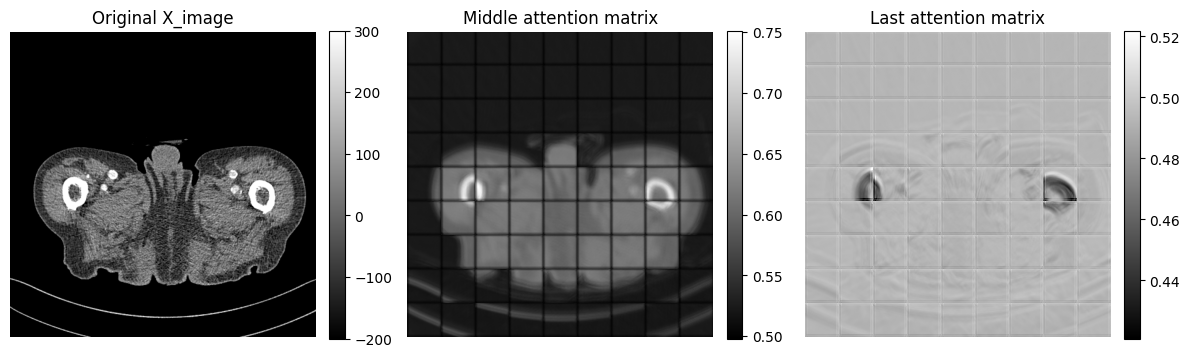

In [ ]:
# 0번째 장기에 대한 attention
i = 0
selected_att_3 = att_matrix3[:, i, :, :].unsqueeze(1)
selected_att_5 = att_matrix5[:, i, :, :].unsqueeze(1)
att_matrix3_img = reconstruct_image(prediction=selected_att_3, patch_size=att_matrix3.shape[-1])
att_matrix5_img = reconstruct_image(prediction=selected_att_5, patch_size=att_matrix5.shape[-1])

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# 첫 번째 이미지
im0 = axes[0].imshow(trans_img(X_test), cmap='gray', vmin=-200, vmax=300)
axes[0].set_title("Original X_image")
axes[0].axis('off')
fig.colorbar(im0, ax=axes[0], orientation='vertical', fraction=0.046, pad=0.04)

# 두 번째 이미지
im1 = axes[1].imshow(np.squeeze(att_matrix3_img.detach().cpu().numpy()), cmap='gray')
axes[1].set_title("Middle attention matrix")
axes[1].axis('off')
fig.colorbar(im1, ax=axes[1], orientation='vertical', fraction=0.046, pad=0.04)

# 세 번째 이미지
im2 = axes[2].imshow(np.squeeze(att_matrix5_img.detach().cpu().numpy()), cmap='gray')
axes[2].set_title("Last attention matrix")
axes[2].axis('off')
fig.colorbar(im2, ax=axes[2], orientation='vertical', fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

In [ ]:
import os

# 저장할 폴더 생성
save_dir = f"{root}/output_images/best"
os.makedirs(save_dir, exist_ok=True)

# 확률이 높은 순으로 정렬
sorted_indices = torch.argsort(logits_list, descending=True)  # 높은 확률 순으로 정렬
sorted_probs = logits_list[sorted_indices]  # 정렬된 확률값
sorted_organs = [text_descriptions[i] for i in sorted_indices]  # 정렬된 장기 이름

for rank, i in enumerate(sorted_indices):  # 정렬된 순서대로 반복
    selected_att_3 = att_matrix3[:, i, :, :].unsqueeze(1)
    selected_att_5 = att_matrix5[:, i, :, :].unsqueeze(1)

    att_matrix3_img = reconstruct_image(prediction=selected_att_3, patch_size=att_matrix3.shape[-1])
    att_matrix5_img = reconstruct_image(prediction=selected_att_5, patch_size=att_matrix5.shape[-1])

    organ_name = sorted_organs[rank]  # 현재 장기 이름
    probability = sorted_probs[rank].item()  # 현재 장기에 대한 확률

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    fig.suptitle(f"Rank {rank+1}: {organ_name} | Probability: {probability:.4f}", fontsize=14, fontweight='bold')

    # 첫 번째 이미지
    im0 = axes[0].imshow(trans_img(X_test), cmap='gray', vmin=-200, vmax=300)
    axes[0].set_title("Original X_image")
    axes[0].axis('off')
    fig.colorbar(im0, ax=axes[0], orientation='vertical', fraction=0.046, pad=0.04)

    # 두 번째 이미지
    im1 = axes[1].imshow(np.squeeze(att_matrix3_img.detach().cpu().numpy()), cmap='gray')
    axes[1].set_title(f"Middle attention matrix")
    axes[1].axis('off')
    fig.colorbar(im1, ax=axes[1], orientation='vertical', fraction=0.046, pad=0.04)

    # 세 번째 이미지
    im2 = axes[2].imshow(np.squeeze(att_matrix5_img.detach().cpu().numpy()), cmap='gray')
    axes[2].set_title(f"Last attention matrix")
    axes[2].axis('off')
    fig.colorbar(im2, ax=axes[2], orientation='vertical', fraction=0.046, pad=0.04)

    plt.tight_layout()

    # 이미지 저장
    save_path = os.path.join(save_dir, f"rank_{rank+1}_{organ_name}.png")
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

    print(f"Saved: {save_path}")

Output hidden; open in https://colab.research.google.com to view.

### 2. worst

In [ ]:
X_test,y_test,X_hat = worst
X_test.shape

torch.Size([81, 1, 55, 55])

In [ ]:
reconstruct_image(X_test).shape

torch.Size([1, 495, 495])

In [ ]:
import torch
import torch.nn.functional as F
from PIL import Image
from open_clip import create_model_from_pretrained, get_tokenizer

# 모델 및 전처리기 로드
model_name = 'hf-hub:microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224'
clip_model, preprocess = create_model_from_pretrained(model_name)
tokenizer = get_tokenizer(model_name)

# 모델을 평가 모드로 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
clip_model.to(device)
clip_model.eval()

image_tensor = reconstruct_image(X_test) # torch.Size([1, 495, 495])

# 텍스트
text_input = tokenizer(text_descriptions).to(device)

# Tensor를 BiomedCLIP이 처리할 수 있는 형태로 변환
def preprocess_tensor(img_tensor):
    # 1채널 → 3채널 (Grayscale → RGB)
    img_tensor = img_tensor.repeat(1, 3, 1, 1)  # (81, 1, 55, 55) → (81, 3, 55, 55)

    # 크기 조정 (55x55 → 224x224)
    img_tensor = F.interpolate(img_tensor, size=(224, 224), mode="bilinear", align_corners=False)

    return img_tensor

# 이미지 변환 후 BiomedCLIP 입력
image_input = preprocess_tensor(image_tensor).to(device)

# 예측 수행
with torch.no_grad():
    image_features, text_features, logit_scale = clip_model(image_input, text_input)
    logits = (logit_scale * image_features @ text_features.T).softmax(dim=-1)

# 결과 출력
for i, text in enumerate(text_descriptions):
    print(f'{text}: {logits[0][i].item():.4f}')

skull: 0.0032
ventricles: 0.0226
lungs: 0.0024
mediastinum: 0.1098
liver: 0.0001
kidneys: 0.0114
pancreas: 0.0000
spleen: 0.0034
abdominal aorta: 0.0054
spine: 0.8413
lymph nodes: 0.0003


In [ ]:
logits_list = logits.squeeze(0)
logits_list.shape, logits_list.sum()

(torch.Size([11]), tensor(1., device='cuda:0'))

In [ ]:
# prob
expanded_logits = logits.expand(81, -1)
expanded_logits.shape

torch.Size([81, 11])

In [ ]:
X_test.shape, expanded_logits.shape

(torch.Size([81, 1, 55, 55]), torch.Size([81, 11]))

In [ ]:
X_test.to(device)
output = model(X_test.cuda(), expanded_logits.cuda())
output.shape

torch.Size([81, 1, 55, 55])

In [ ]:
# Forward Pass
output = model(X_test, expanded_logits)

att_matrix3 = model.spatial_attention3.last_attention
att_matrix5 = model.spatial_attention5.last_attention

att_matrix3.shape, att_matrix5.shape

(torch.Size([81, 11, 43, 43]), torch.Size([81, 11, 35, 35]))

여기서부터 시각화 확인

In [ ]:
i = 0
selected_att_3 = att_matrix3[:, i, :, :].unsqueeze(1)
selected_att_3.shape

torch.Size([81, 1, 43, 43])

In [ ]:
att_matrix3_img = reconstruct_image(prediction=selected_att_3, patch_size=att_matrix3.shape[-1])
att_matrix3_img.shape

torch.Size([1, 387, 387])

In [ ]:
import os

# 저장할 폴더 생성
save_dir = f"{root}/output_images/worst"
os.makedirs(save_dir, exist_ok=True)

# 확률이 높은 순으로 정렬
sorted_indices = torch.argsort(logits_list, descending=True)  # 높은 확률 순으로 정렬
sorted_probs = logits_list[sorted_indices]  # 정렬된 확률값
sorted_organs = [text_descriptions[i] for i in sorted_indices]  # 정렬된 장기 이름

for rank, i in enumerate(sorted_indices):  # 정렬된 순서대로 반복
    selected_att_3 = att_matrix3[:, i, :, :].unsqueeze(1)
    selected_att_5 = att_matrix5[:, i, :, :].unsqueeze(1)

    att_matrix3_img = reconstruct_image(prediction=selected_att_3, patch_size=att_matrix3.shape[-1])
    att_matrix5_img = reconstruct_image(prediction=selected_att_5, patch_size=att_matrix5.shape[-1])

    organ_name = sorted_organs[rank]  # 현재 장기 이름
    probability = sorted_probs[rank].item()  # 현재 장기에 대한 확률

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    fig.suptitle(f"Rank {rank+1}: {organ_name} | Probability: {probability:.4f}", fontsize=14, fontweight='bold')

    # 첫 번째 이미지
    im0 = axes[0].imshow(trans_img(X_test), cmap='gray', vmin=-200, vmax=300)
    axes[0].set_title("Original X_image")
    axes[0].axis('off')
    fig.colorbar(im0, ax=axes[0], orientation='vertical', fraction=0.046, pad=0.04)

    # 두 번째 이미지
    im1 = axes[1].imshow(np.squeeze(att_matrix3_img.detach().cpu().numpy()), cmap='gray')
    axes[1].set_title(f"Middle attention matrix")
    axes[1].axis('off')
    fig.colorbar(im1, ax=axes[1], orientation='vertical', fraction=0.046, pad=0.04)

    # 세 번째 이미지
    im2 = axes[2].imshow(np.squeeze(att_matrix5_img.detach().cpu().numpy()), cmap='gray')
    axes[2].set_title(f"Last attention matrix")
    axes[2].axis('off')
    fig.colorbar(im2, ax=axes[2], orientation='vertical', fraction=0.046, pad=0.04)

    plt.tight_layout()

    # 이미지 저장
    save_path = os.path.join(save_dir, f"rank_{rank+1}_{organ_name}.png")
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

    print(f"Saved: {save_path}")

Output hidden; open in https://colab.research.google.com to view.